In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
import os
from module import Model_Training
import logging
tf.get_logger().setLevel(logging.ERROR)


2023-03-10 21:05:09.993308: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-10 21:05:10.995452: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/include:/usr/local/cuda/lib64:/usr/local/cuda-11.2/lib64::/usr/local/cuda/extras/CUPTI/lib64:/home/jj/miniconda3/envs/tf/lib/
2023-03-10 21:05:10.995536: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LI

In [2]:
# full_img_path = '/mnt/d/Datasets/CBIS_DDSM_3/full/'
roi_img_path = '/mnt/d/CBIS-DDSM/new_ROI/resize_GCN_3/'
img_height = 300
img_width = 300
batch_size = 16
os.environ['TF_ENABLE_GPU_GARBAGE_COLLECTION'] = 'false'
misclassified_store = '/mnt/c/Users/user/Desktop/GCN_CBIS_DDSM_3_misclassified/'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = tf.keras.utils.image_dataset_from_directory(
  roi_img_path+'train/',
  label_mode="categorical",
  image_size=(img_height, img_width),
  batch_size=batch_size)
val_ds = tf.keras.utils.image_dataset_from_directory(
  roi_img_path+'val/',
  label_mode="categorical",
  image_size=(img_height, img_width),
  batch_size=batch_size)
train = train_ds.prefetch(AUTOTUNE)
val = val_ds.prefetch(AUTOTUNE)

Found 6648 files belonging to 2 classes.
Found 183 files belonging to 2 classes.


In [4]:
test = tf.keras.utils.image_dataset_from_directory(
  roi_img_path+'test/',
  label_mode="categorical",
  image_size=(img_height, img_width),
  shuffle=False,
  batch_size=batch_size)
train_test = tf.keras.utils.image_dataset_from_directory(
  roi_img_path+'train/',
  label_mode="categorical",
  image_size=(img_height, img_width),
  shuffle=False,
  batch_size=batch_size)
val_test = tf.keras.utils.image_dataset_from_directory(
  roi_img_path+'val/',
  label_mode="categorical",
  image_size=(img_height, img_width),
  shuffle=False,
  batch_size=batch_size)
# test = test_ds.prefetch(AUTOTUNE)

Found 311 files belonging to 2 classes.
Found 6648 files belonging to 2 classes.
Found 183 files belonging to 2 classes.


In [5]:
class PrintLR(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = tf.keras.backend.get_value(self.model.optimizer.lr)
        print(
            f' Epoch {epoch}: accuracy={logs["categorical_accuracy"]:.4f}, loss={logs["loss"]:.4f}, '+
            f'val_accuracy={logs["val_categorical_accuracy"]:.4f}, val_loss={logs["val_loss"]:.4f}, '+
            f' - lr={lr:.7f}')
Model_Training = Model_Training()

# Inception V3

In [6]:
train_log = '/home/jj/FYP/log/InceptionV3_CBIS_DDSM_3/'
weight = '/home/jj/FYP/Checkpoint/InceptionV3_CBIS_DDSM_3/'

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 300, 300, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 300, 300, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0     

2023-03-10 02:02:28.954930: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-03-10 02:02:31.197829: W tensorflow/tsl/framework/bfc_allocator.cc:360] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.
2023-03-10 02:02:31.889385: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-03-10 02:02:31.908207: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f4324030bd0 initialized for platform CUDA (this does not guarantee

416/416 [==============================] - 250s 568ms/step - loss: 1.3910 - categorical_accuracy: 0.5167 - recall: 0.2468 - recall_1: 0.7624 - val_loss: 1.3250 - val_categorical_accuracy: 0.4372 - val_recall: 0.5122 - val_recall_1: 0.3762
Epoch 2/2
416/416 [==============================] - 65s 155ms/step - loss: 1.3181 - categorical_accuracy: 0.5069 - recall: 0.4760 - recall_1: 0.5351 - val_loss: 1.2959 - val_categorical_accuracy: 0.5683 - val_recall: 0.4390 - val_recall_1: 0.6733
Epoch 3/3
416/416 [==============================] - 66s 158ms/step - loss: 1.2938 - categorical_accuracy: 0.5376 - recall: 0.4722 - recall_1: 0.5971 - val_loss: 1.2779 - val_categorical_accuracy: 0.5902 - val_recall: 0.6341 - val_recall_1: 0.5545
Epoch 4/4
416/416 [==============================] - 66s 158ms/step - loss: 1.2632 - categorical_accuracy: 0.5698 - recall: 0.4962 - recall_1: 0.6368 - val_loss: 1.2537 - val_categorical_accuracy: 0.6011 - val_recall: 0.8415 - val_recall_1: 0.4059
Epoch 5/5
416/416

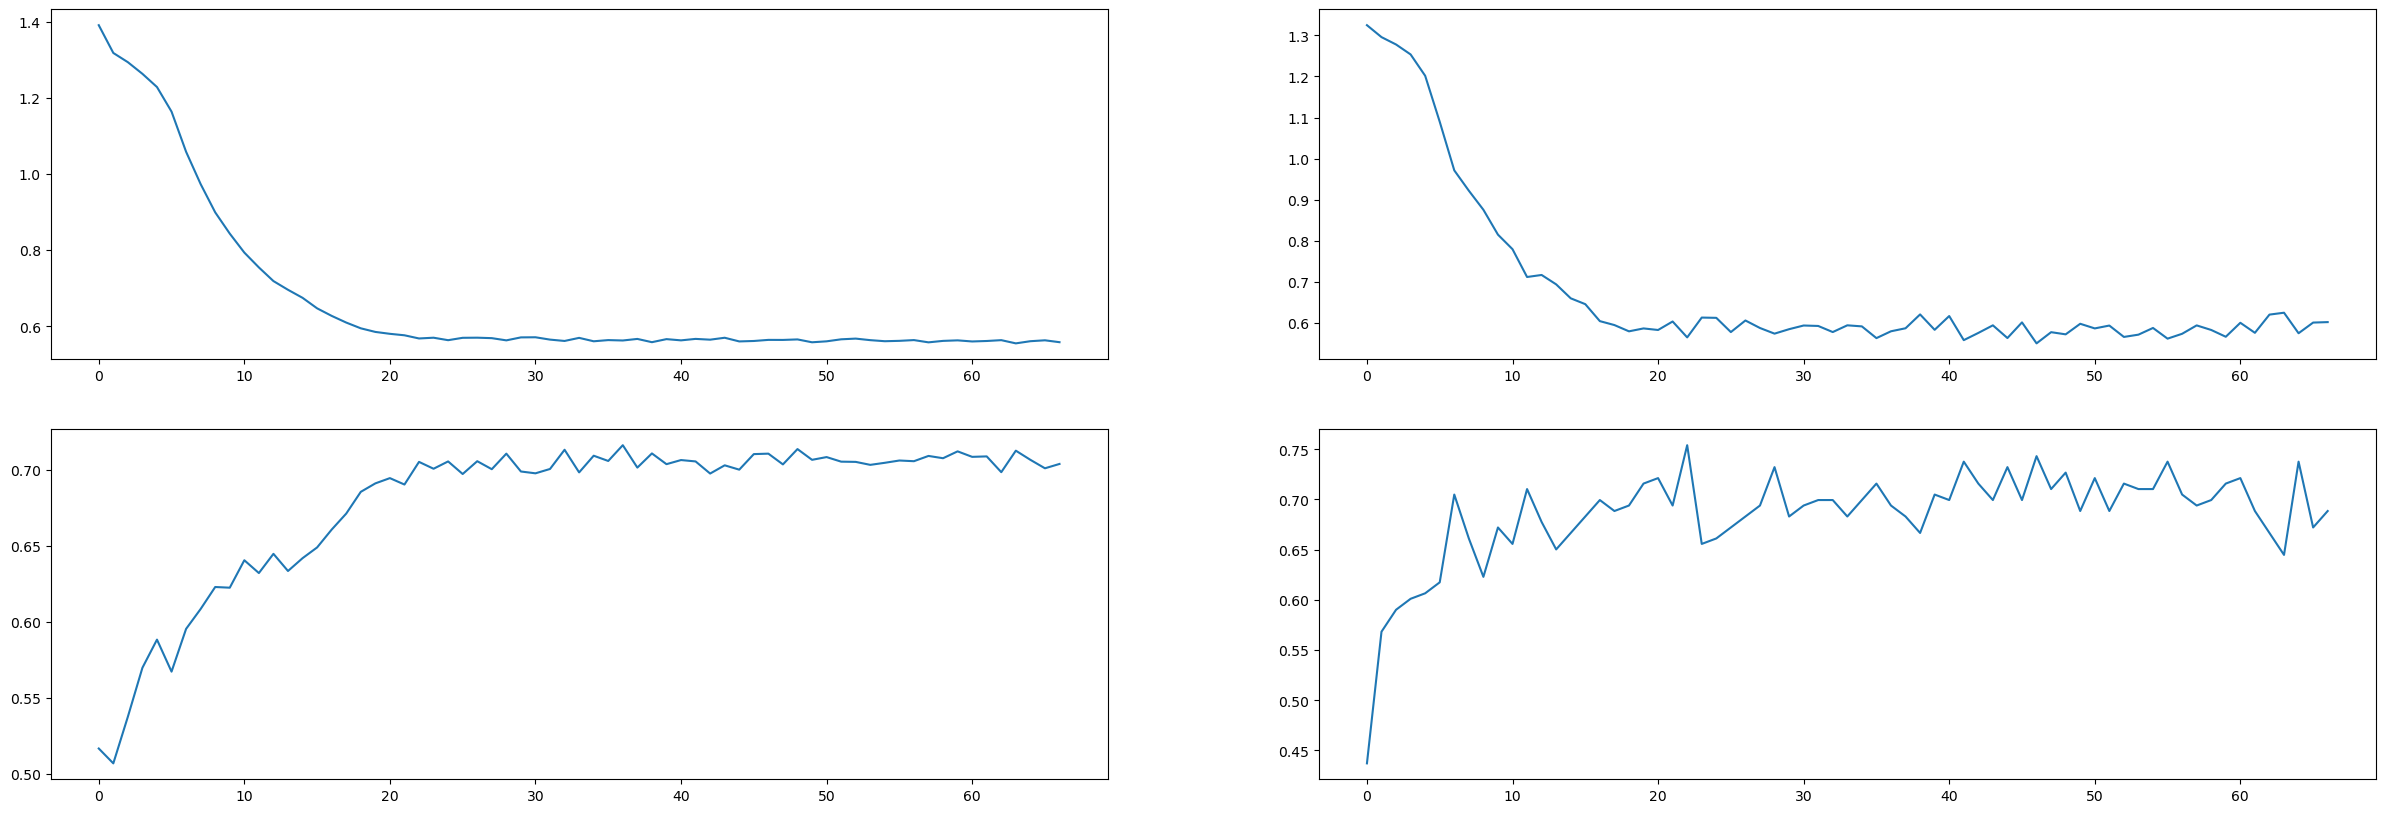

In [7]:
tf.keras.backend.clear_session()
model, inception_dense_history = Model_Training.main(    
    'inceptionv3',
    train,
    val,
    epochs=100,
    patience=2,
    Earlystop=20,
    augmentation = True,
    flatten='global_average_pooling',
    trainable_layers = False,
    regulariser=tf.keras.regularizers.l2(l2=0.1),
    train_log=train_log+'dense.csv',
    load_weights = False,
    save_weights = weight+'Dense/best_model',
    learning_rate=1e-4,init_lr=1e-6,
    optimiser=tf.keras.optimizers.Adam(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Recall(class_id=0),tf.keras.metrics.Recall(class_id=1)],
    callbacks = [PrintLR()],
    img_height=img_height,img_width=img_width)

## Fine Tune

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 300, 300, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 300, 300, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0     

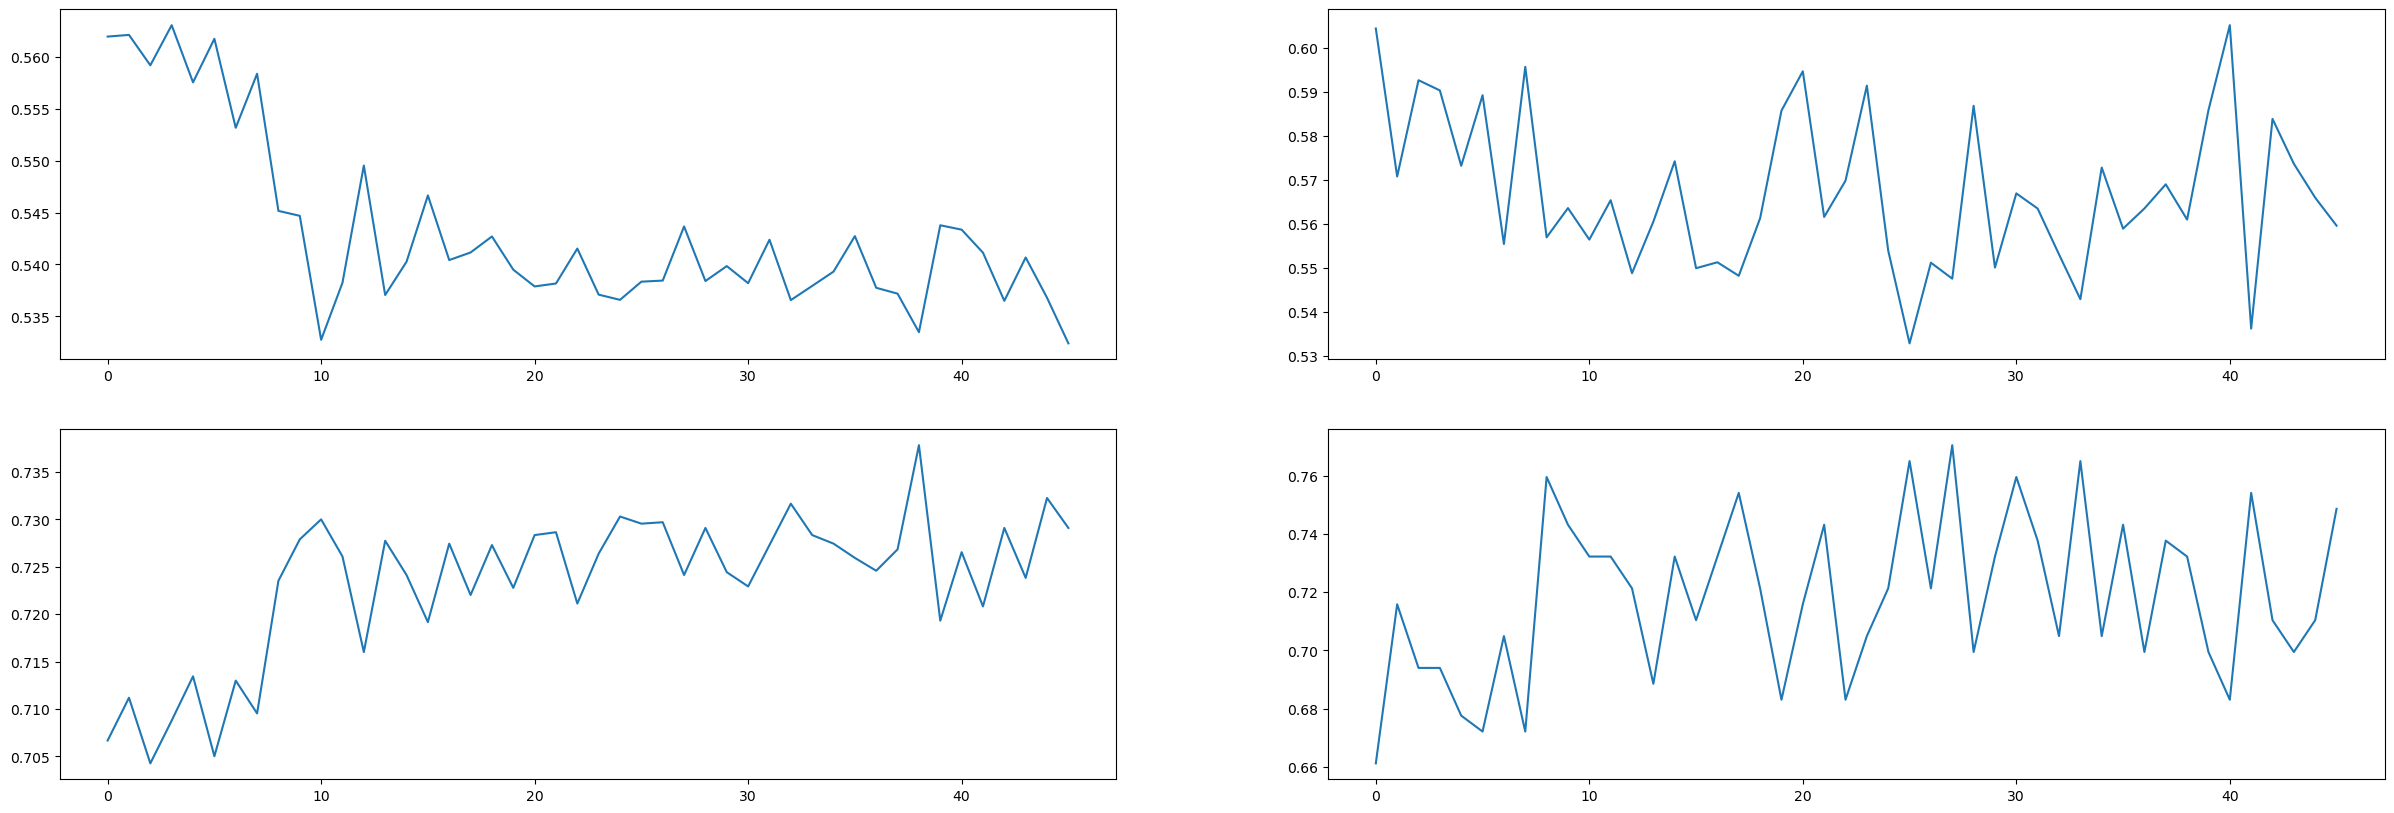

In [8]:
tf.keras.backend.clear_session()
model, inception_fine_tune_history = Model_Training.main(    
    'inceptionv3',
    train,
    val,
    epochs=100,
    patience=2,
    Earlystop=20,
    augmentation = True,
    flatten='global_average_pooling',
    trainable_layers = 63,
    regulariser=tf.keras.regularizers.l2(l2=0.1),
    train_log=train_log+'Fine_Tune.csv',
    load_weights = weight+'Dense/best_model',
    save_weights = weight+'Fine_Tune/best_model',
    learning_rate=1e-4,init_lr=1e-6,
    optimiser=tf.keras.optimizers.legacy.SGD(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()],
    img_height=img_height,img_width=img_width)

## Test

In [7]:
tf.keras.backend.clear_session()
metric = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),
          tf.keras.metrics.AUC()]

model = Model_Training.build_model('inceptionv3',augmentation=False,Flatten='global_average_pooling',load_weights=weight+'/Fine_Tune/best_model',metrics=metric)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 300, 300, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 300, 300, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                             

In [8]:
store_misclassified = misclassified_store+'inceptionv3/'
model.evaluate(test)
misclassified_inceptionv3_test = Model_Training.store_misclassified(model,test,store_misclassified+'test/')
misclassified_inceptionv3_train = Model_Training.store_misclassified(model,train_test,store_misclassified+'train/')
misclassified_inceptionv3_val = Model_Training.store_misclassified(model,val_test,store_misclassified+'val/')

2023-03-10 07:10:45.345697: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-03-10 07:10:47.512043: W tensorflow/tsl/framework/bfc_allocator.cc:360] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


 3/20 [===>..........................] - ETA: 0s - loss: 0.7147 - categorical_accuracy: 0.6250 - precision: 0.6250 - recall: 0.6250 - auc: 0.6128  

2023-03-10 07:10:48.196097: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


12/12 [==============================] - 6s 481ms/step


20/20 [==============================] - 1s 32ms/step


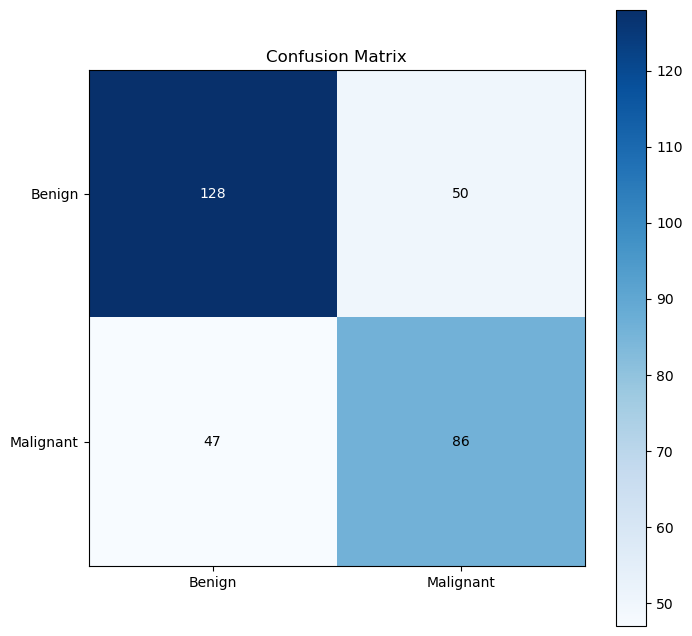

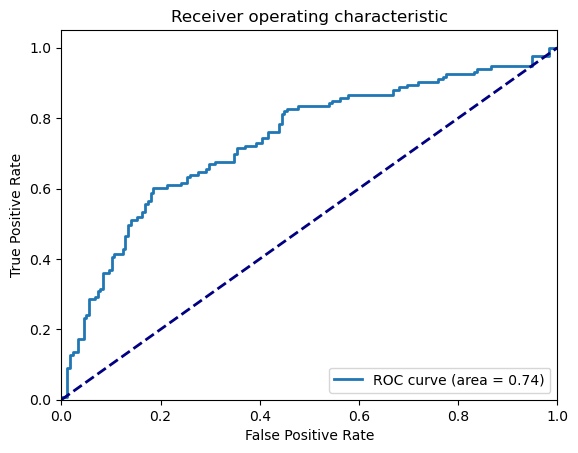

In [9]:
model.load_weights(weight+'/Fine_Tune/best_model')
model.evaluate(test)
prediction = model.predict(test)
cm = Model_Training.confusion_matrix(test,prediction)
AUC = Model_Training.AUC(test,prediction)
tf.keras.backend.clear_session()

20/20 [==============================] - 1s 44ms/step - loss: 0.6261 - categorical_accuracy: 0.6945 - precision: 0.6945 - recall: 0.6945 - auc: 0.7432

# Resnet50

## Initialising

In [10]:
weights = '/home/jj/FYP/Checkpoint/Resnet50_CBIS_DDSM_3/'
train_log = '/home/jj/FYP/log/Resnet50_CBIS_DDSM_3/'

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 300, 300, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 300, 300, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 10, 10, 2048)      23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                      

2023-03-10 07:21:59.393348: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fc07816dc60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-10 07:21:59.393377: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2023-03-10 07:21:59.409238: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-10 07:21:59.571887: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


416/416 [==============================] - 76s 170ms/step - loss: 0.7139 - categorical_accuracy: 0.4995 - recall: 0.5407 - recall_1: 0.4618 - val_loss: 0.7043 - val_categorical_accuracy: 0.4754 - val_recall: 0.4634 - val_recall_1: 0.4851
Epoch 2/2
416/416 [==============================] - 68s 162ms/step - loss: 0.6881 - categorical_accuracy: 0.5346 - recall: 0.5786 - recall_1: 0.4945 - val_loss: 0.6762 - val_categorical_accuracy: 0.5738 - val_recall: 0.3902 - val_recall_1: 0.7228
Epoch 3/3
416/416 [==============================] - 68s 164ms/step - loss: 0.6755 - categorical_accuracy: 0.5665 - recall: 0.6215 - recall_1: 0.5164 - val_loss: 0.6661 - val_categorical_accuracy: 0.5792 - val_recall: 0.4146 - val_recall_1: 0.7129
Epoch 4/4
416/416 [==============================] - 67s 161ms/step - loss: 0.6554 - categorical_accuracy: 0.5925 - recall: 0.6670 - recall_1: 0.5247 - val_loss: 0.6615 - val_categorical_accuracy: 0.5902 - val_recall: 0.7195 - val_recall_1: 0.4851
Epoch 5/5
416/416 

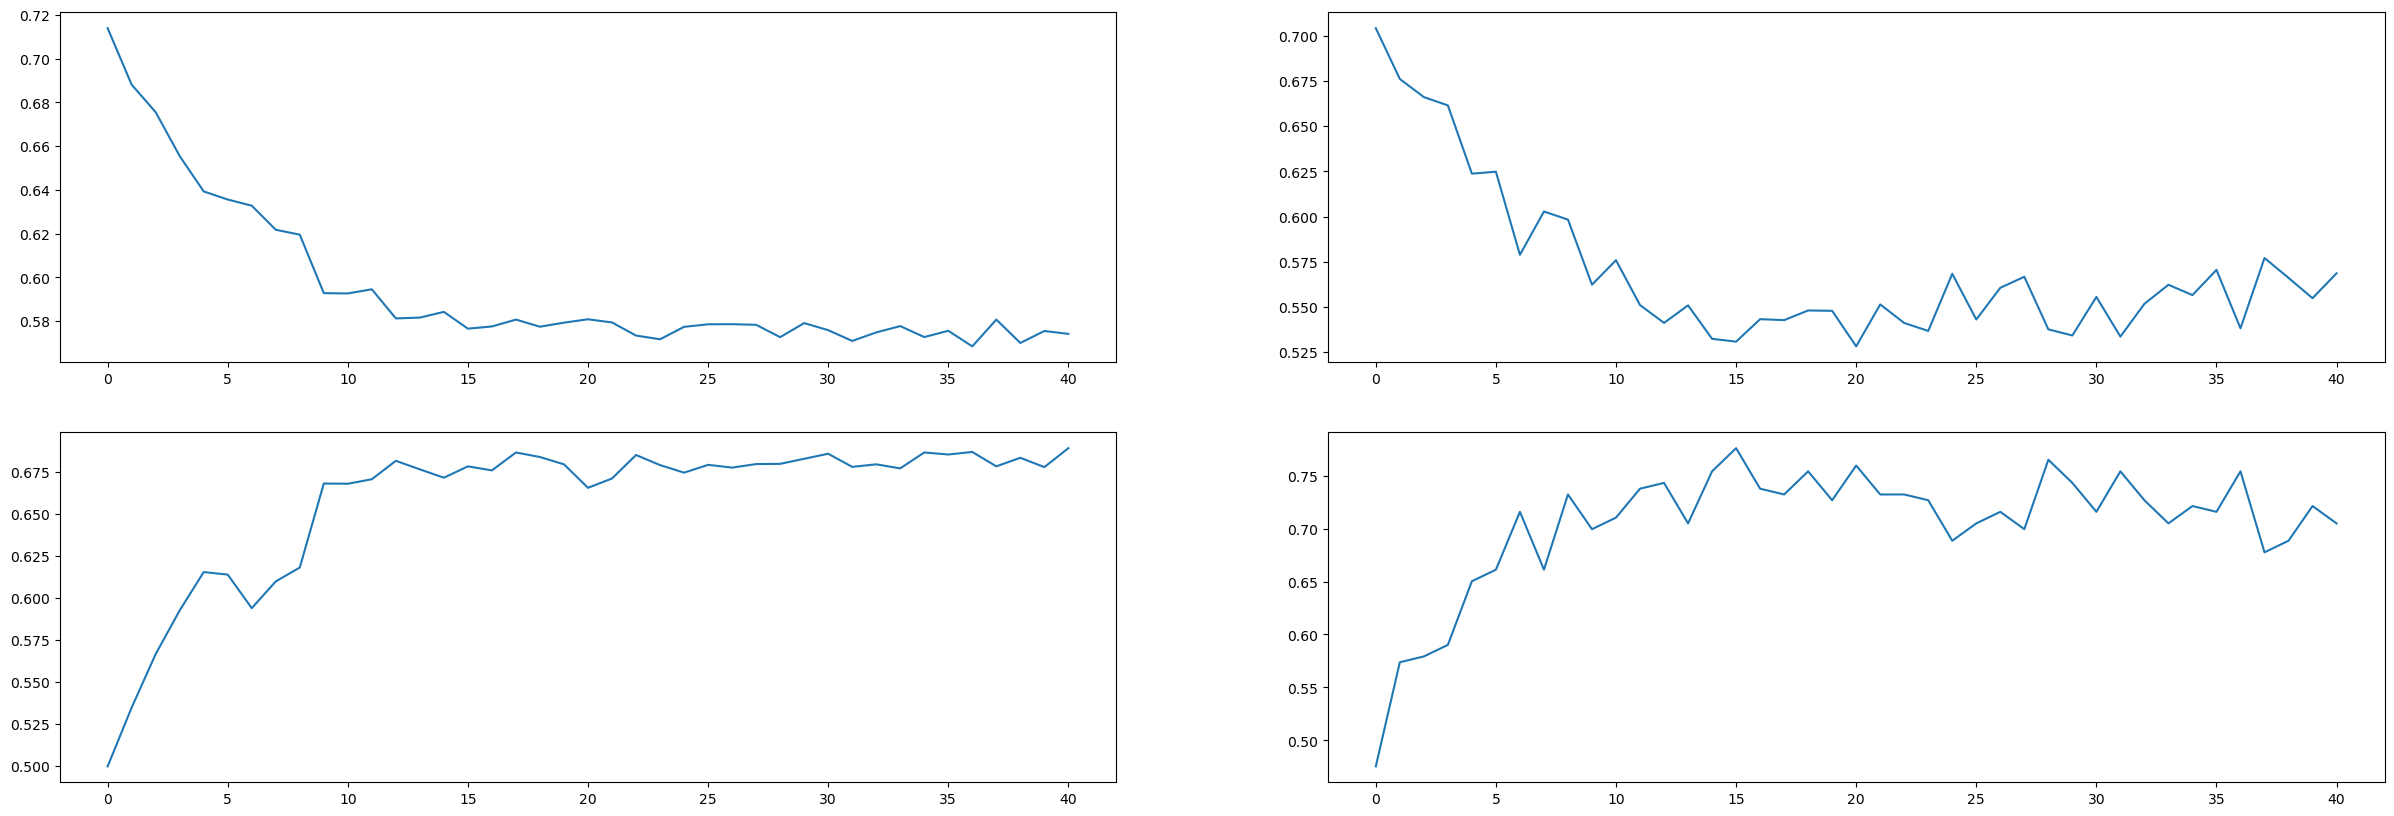

In [12]:
tf.keras.backend.clear_session()
model, resnet_dense_history = Model_Training.main(    
    'resnet50',
    train,
    val,
    epochs=100,
    patience=2,
    Earlystop=20,
    augmentation = True,
    trainable_layers = False,
    # regulariser=tf.keras.regularizers.l2(l2=0.1),
    train_log= train_log+'dense.csv',
    load_weights = False,
    save_weights = weights+'Dense/best_model',
    learning_rate=1e-4,init_lr=1e-6,
    optimiser=tf.keras.optimizers.Adam(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Recall(class_id=0),tf.keras.metrics.Recall(class_id=1)],
    callbacks = [PrintLR()],
    img_height=img_height,img_width=img_width)

## Fine Tune

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 300, 300, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 300, 300, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 10, 10, 2048)      23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                      

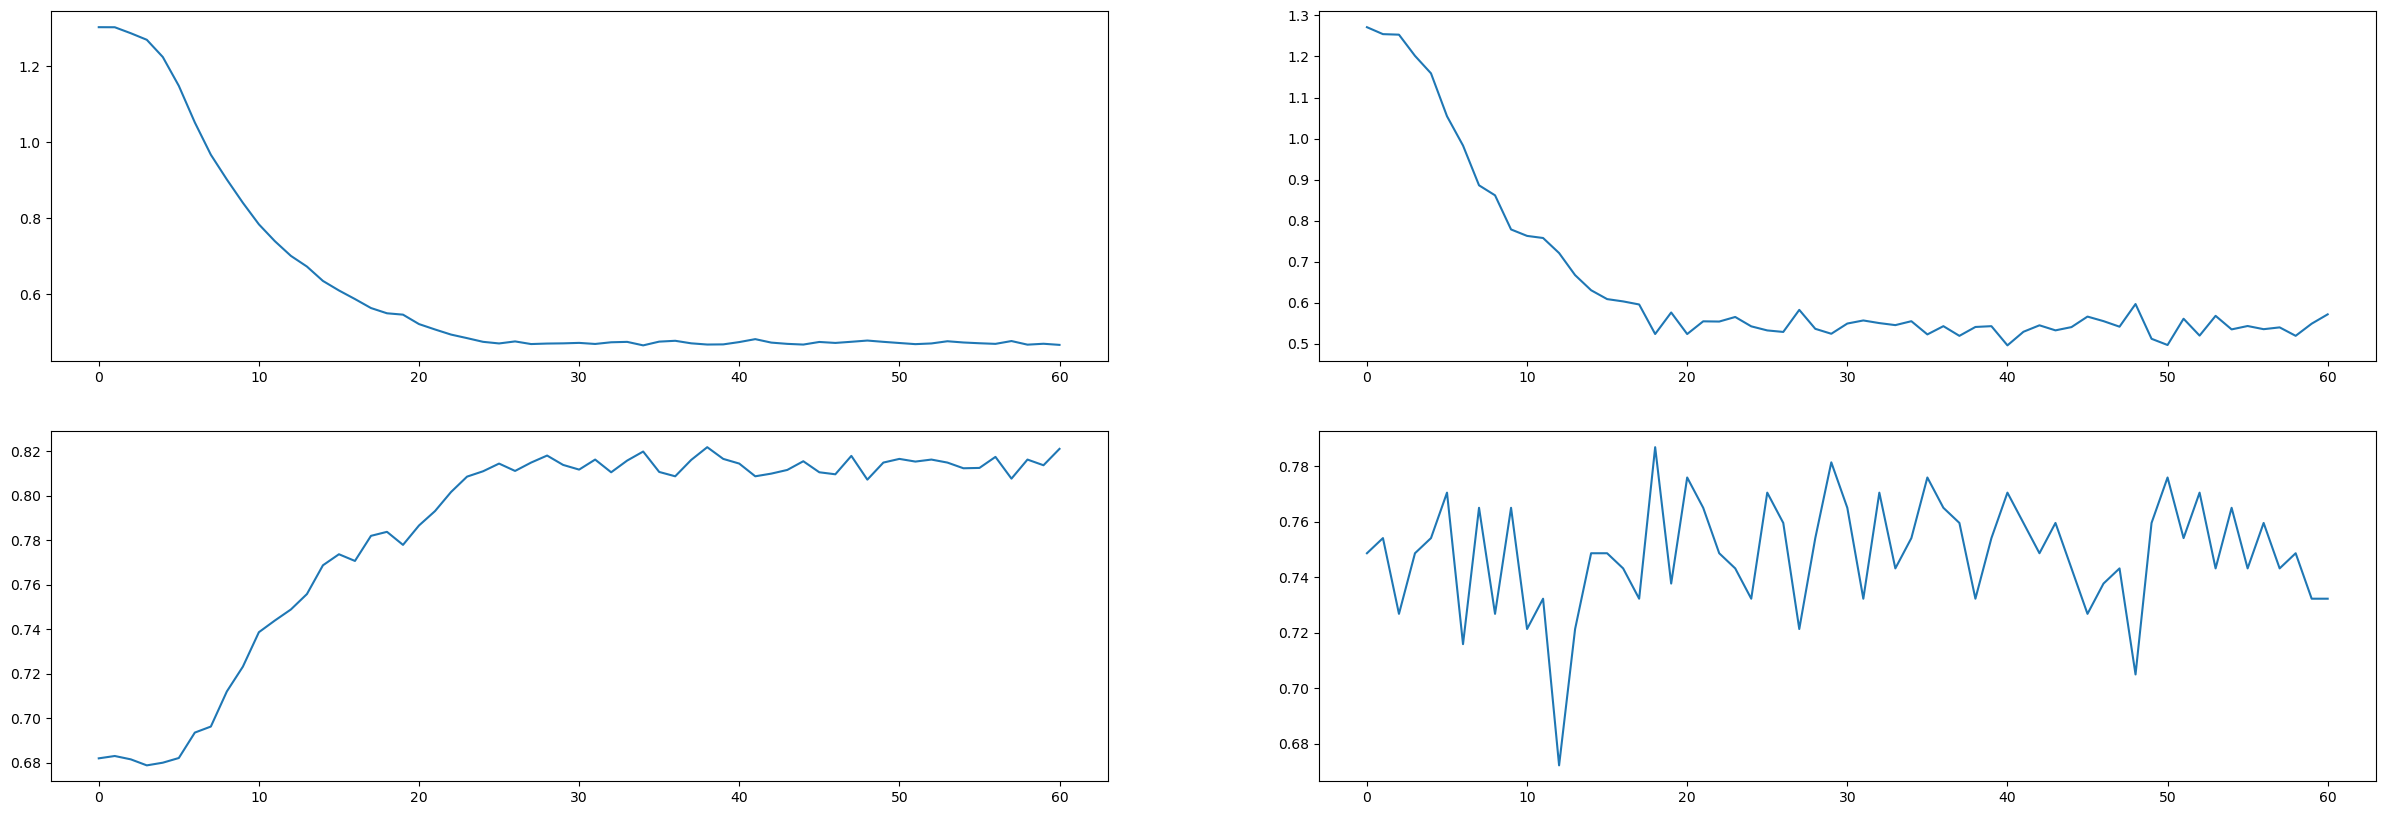

In [13]:
tf.keras.backend.clear_session()
model, resnet_fine_tune_history = Model_Training.main(    
    'resnet50',
    train,
    val,
    epochs=100,
    patience=2,
    Earlystop=20,
    augmentation = True,
    trainable_layers = 22,
    regulariser=tf.keras.regularizers.l2(l2=0.1),
    train_log= train_log+'Fine_Tune.csv',
    load_weights = weights+'Dense/best_model',
    save_weights = weights+'Fine_Tune/best_model',
    learning_rate=1e-3,init_lr=1e-6,
    optimiser=tf.keras.optimizers.legacy.SGD(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Recall(class_id=0),tf.keras.metrics.Recall(class_id=1)],
    callbacks = [PrintLR()],
    img_height=img_height,img_width=img_width)

## Test

In [14]:
tf.keras.backend.clear_session()
metric = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),
          tf.keras.metrics.AUC()]
model = Model_Training.build_model('resnet50',augmentation=False,Flatten='global_average_pooling',load_weights=weights+'Fine_Tune/best_model',metrics=metric)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 300, 300, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 300, 300, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 10, 10, 2048)      23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              209817

In [15]:
store_misclassified = misclassified_store+'resnet50/'
model.evaluate(test)
misclassified_inceptionv3_test = Model_Training.store_misclassified(model,test,store_misclassified+'test/')
misclassified_inceptionv3_train = Model_Training.store_misclassified(model,train_test,store_misclassified+'train/')
misclassified_inceptionv3_val = Model_Training.store_misclassified(model,val_test,store_misclassified+'val/')

12/12 [==============================] - 1s 56ms/step


20/20 [==============================] - 1s 40ms/step


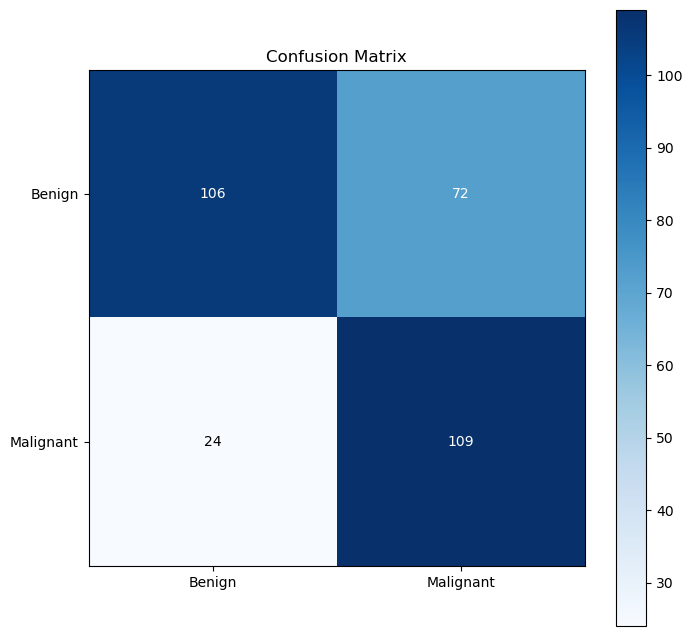

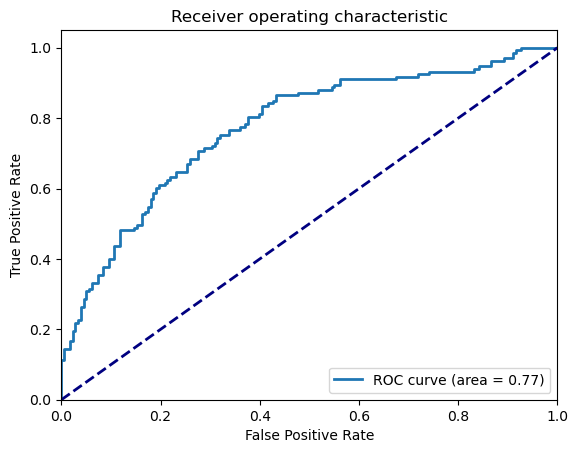

In [16]:
model.load_weights(weights+'Fine_Tune/best_model')
model.evaluate(test)
prediction = model.predict(test)
cm = Model_Training.confusion_matrix(test,prediction)
AUC = Model_Training.AUC(test,prediction)
tf.keras.backend.clear_session()

20/20 [==============================] - 18s 666ms/step - loss: 0.5923 - categorical_accuracy: 0.6817 - precision: 0.6817 - recall: 0.6817 - auc: 0.7646 2nd lr decrease by 2 every epoch

20/20 [==============================] - 1s 44ms/step - loss: 0.6252 - categorical_accuracy: 0.6720 - precision: 0.6720 - recall: 0.6720 - auc: 0.7229 base paper setup

# VGG16

In [17]:
weights = '/home/jj/FYP/Checkpoint/Vgg16_CBIS_DDSM_3/'
train_log = '/home/jj/FYP/log/Vgg16_CBIS_DDSM_3/'

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 300, 300, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 300, 300, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 9, 9, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                      

2023-03-10 09:19:44.144848: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.11GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-03-10 09:19:44.148253: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.11GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


416/416 [==============================] - 74s 165ms/step - loss: 1.4582 - categorical_accuracy: 0.4959 - precision: 0.4644 - precision_1: 0.5158 - val_loss: 1.4427 - val_categorical_accuracy: 0.5355 - val_precision: 0.4545 - val_precision_1: 0.5533
Epoch 2/2
416/416 [==============================] - 65s 155ms/step - loss: 1.4428 - categorical_accuracy: 0.5111 - precision: 0.4867 - precision_1: 0.5322 - val_loss: 1.4253 - val_categorical_accuracy: 0.5738 - val_precision: 0.5667 - val_precision_1: 0.5752
Epoch 3/3
416/416 [==============================] - 65s 155ms/step - loss: 1.4269 - categorical_accuracy: 0.5356 - precision: 0.5228 - precision_1: 0.5403 - val_loss: 1.4140 - val_categorical_accuracy: 0.5738 - val_precision: 0.5476 - val_precision_1: 0.5816
Epoch 4/4
416/416 [==============================] - 65s 155ms/step - loss: 1.4040 - categorical_accuracy: 0.5433 - precision: 0.5202 - precision_1: 0.5655 - val_loss: 1.3937 - val_categorical_accuracy: 0.5683 - val_precision: 0.5

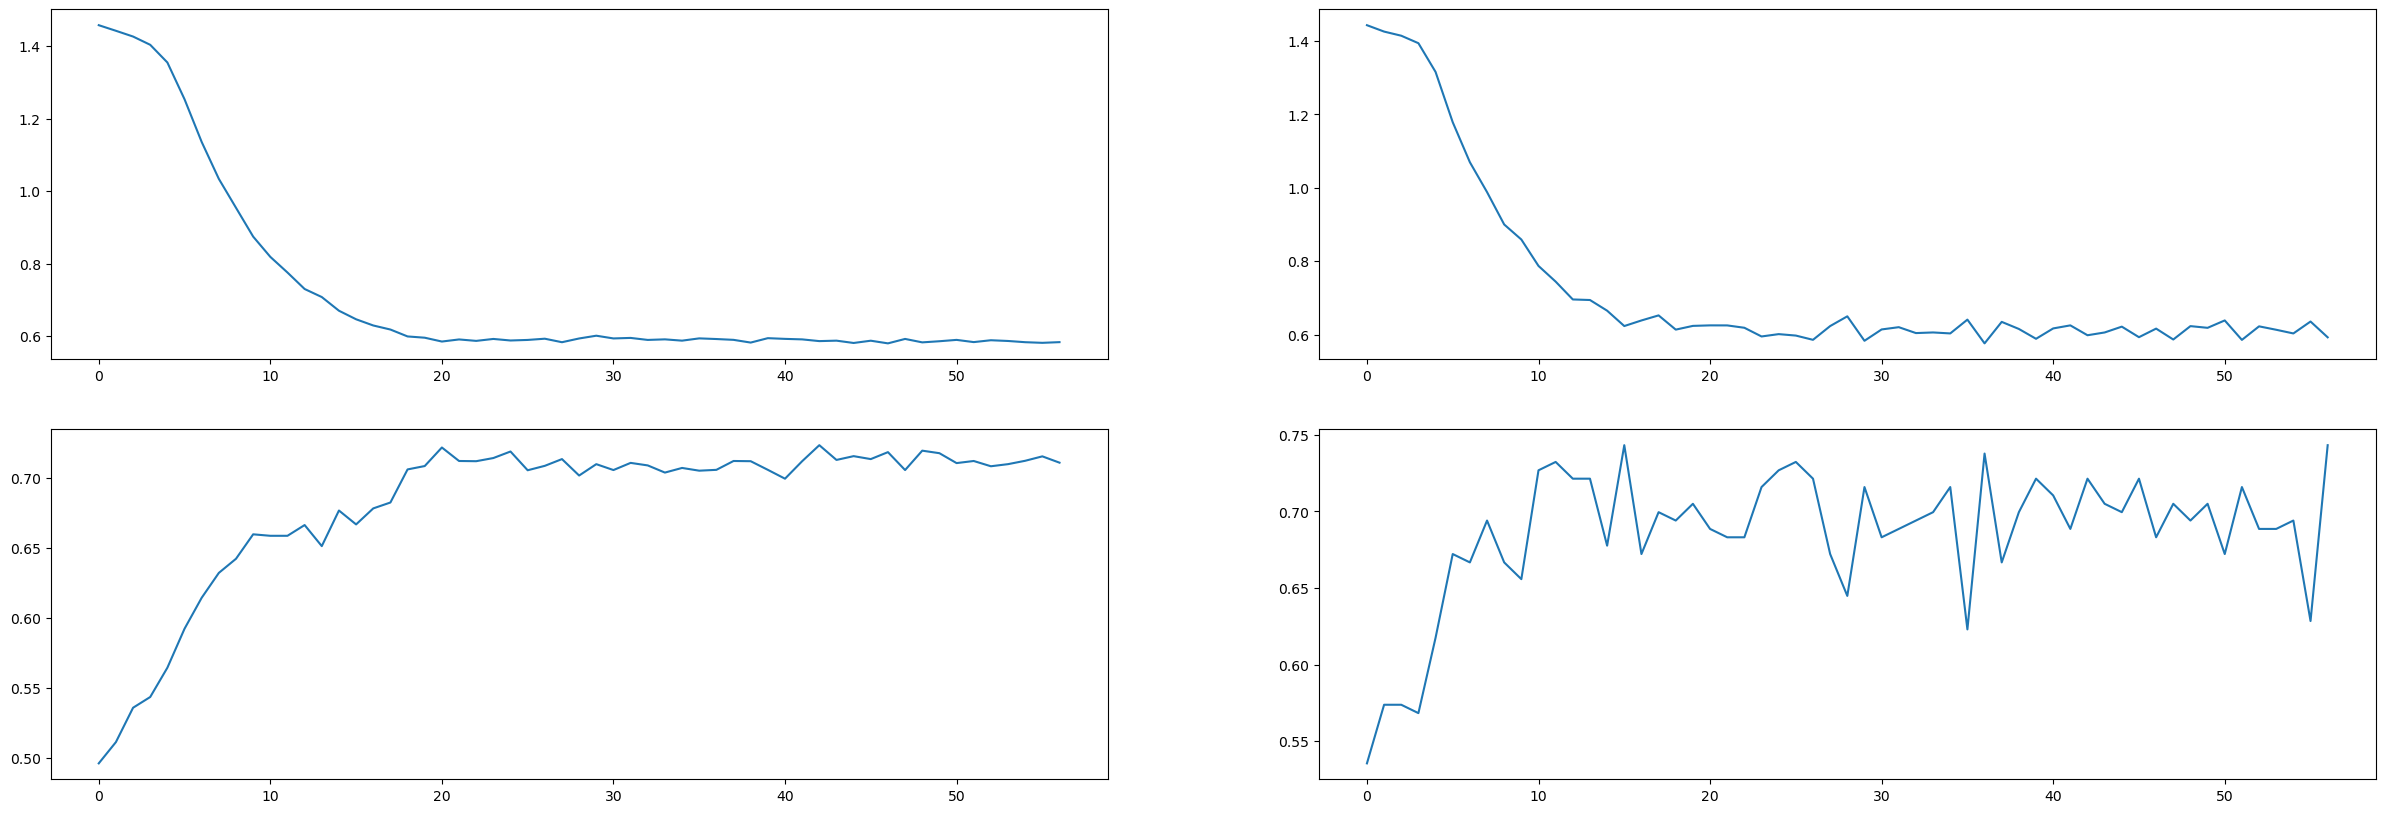

In [18]:
tf.keras.backend.clear_session()
weights = '/home/jj/FYP/Checkpoint/Vgg16_CBIS_DDSM_3/'
train_log = '/home/jj/FYP/log/Vgg16_CBIS_DDSM_3/'
model, vgg16_dense_history = Model_Training.main(    
    'vgg16',
    train,
    val,
    epochs=100,
    patience=2,
    Earlystop=20,
    augmentation = True,
    trainable_layers = False,
    regulariser=tf.keras.regularizers.l2(l2=0.1),
    train_log= train_log+'dense.csv',
    load_weights = False,
    save_weights = weights+'Dense/best_model',
    learning_rate=1e-4,init_lr=1e-6,
    optimiser=tf.keras.optimizers.Adam(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()],
    img_height=img_height,img_width=img_width)

## Fine Tune

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 300, 300, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 300, 300, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 9, 9, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                      

2023-03-10 10:21:37.244344: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.18GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-03-10 10:21:37.244387: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.18GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-03-10 10:21:37.281342: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.40GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-03-10 10:21:37.281383: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU

416/416 [==============================] - 95s 220ms/step - loss: 0.5845 - categorical_accuracy: 0.7204 - precision: 0.6879 - precision_1: 0.7561 - val_loss: 0.5870 - val_categorical_accuracy: 0.7213 - val_precision: 0.6703 - val_precision_1: 0.7717
Epoch 2/2
416/416 [==============================] - 90s 216ms/step - loss: 0.5875 - categorical_accuracy: 0.7189 - precision: 0.6850 - precision_1: 0.7568 - val_loss: 0.6347 - val_categorical_accuracy: 0.6667 - val_precision: 0.6235 - val_precision_1: 0.7041
Epoch 3/3
416/416 [==============================] - 90s 217ms/step - loss: 0.5850 - categorical_accuracy: 0.7180 - precision: 0.6802 - precision_1: 0.7622 - val_loss: 0.5569 - val_categorical_accuracy: 0.7486 - val_precision: 0.7000 - val_precision_1: 0.7957
Epoch 4/4
416/416 [==============================] - 90s 217ms/step - loss: 0.5756 - categorical_accuracy: 0.7223 - precision: 0.6882 - precision_1: 0.7605 - val_loss: 0.5777 - val_categorical_accuracy: 0.7486 - val_precision: 0.7

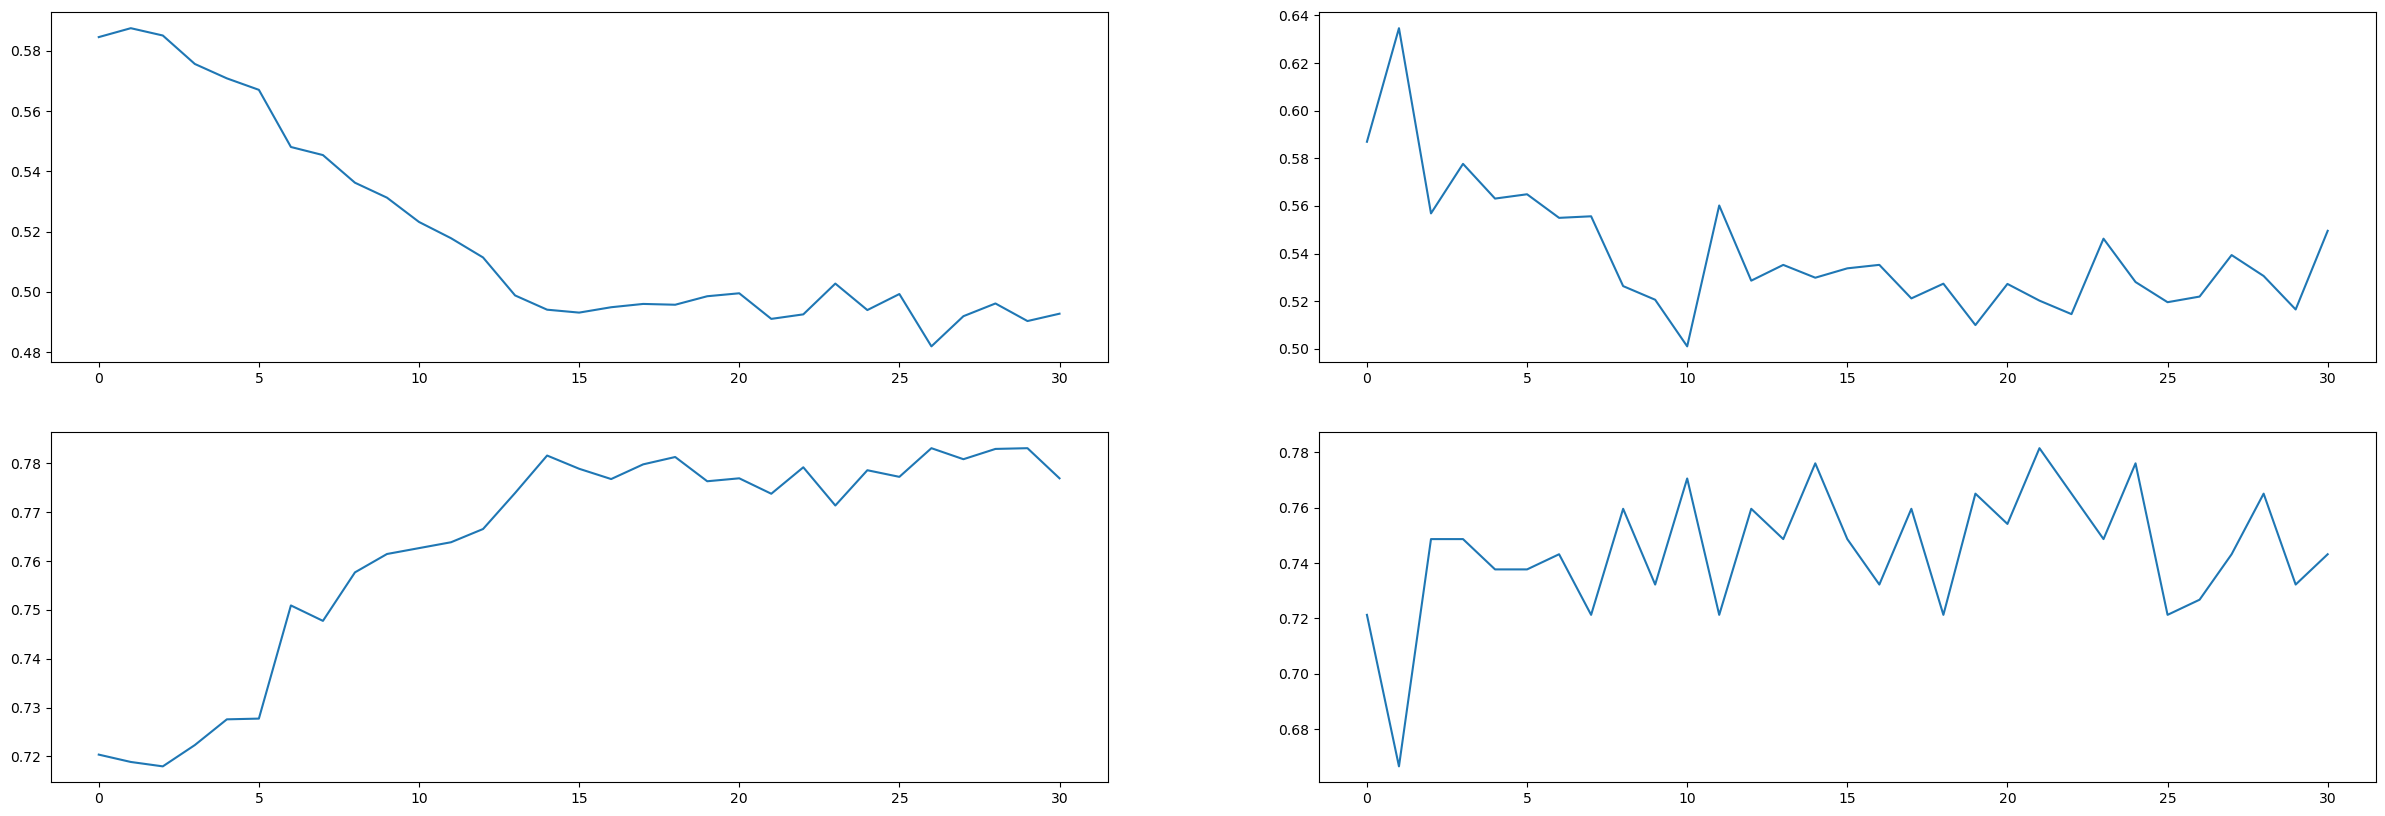

In [19]:
tf.keras.backend.clear_session()
model, vgg16_fine_tune_history = Model_Training.main(    
    'vgg16',
    train,
    val,
    epochs=100,
    patience=2,
    Earlystop=20,
    augmentation = True,
    trainable_layers = 16,
    regulariser=tf.keras.regularizers.l2(l2=0.1),
    train_log= train_log+'Fine_Tune.csv',
    load_weights = weights+'Dense/best_model',
    save_weights = weights+'Fine_Tune/best_model',
    learning_rate=1e-4,init_lr=1e-6,
    optimiser=tf.keras.optimizers.legacy.SGD(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()],
    img_height=img_height,img_width=img_width)

## Test

In [20]:
tf.keras.backend.clear_session()
metric = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=1),tf.keras.metrics.Recall(class_id=1),
          tf.keras.metrics.AUC()]

model = Model_Training.build_model('vgg16',augmentation=False,Flatten='global_average_pooling',load_weights=weights+'Fine_Tune/best_model',metrics=metric)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 300, 300, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 300, 300, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 9, 9, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              525312

In [21]:
store_misclassified = misclassified_store+'vgg16/'
model.evaluate(test)
misclassified_inceptionv3_test = Model_Training.store_misclassified(model,test,store_misclassified+'test/')
misclassified_inceptionv3_train = Model_Training.store_misclassified(model,train_test,store_misclassified+'train/')
misclassified_inceptionv3_val = Model_Training.store_misclassified(model,val_test,store_misclassified+'val/')

12/12 [==============================] - 1s 63ms/step


20/20 [==============================] - 1s 42ms/step


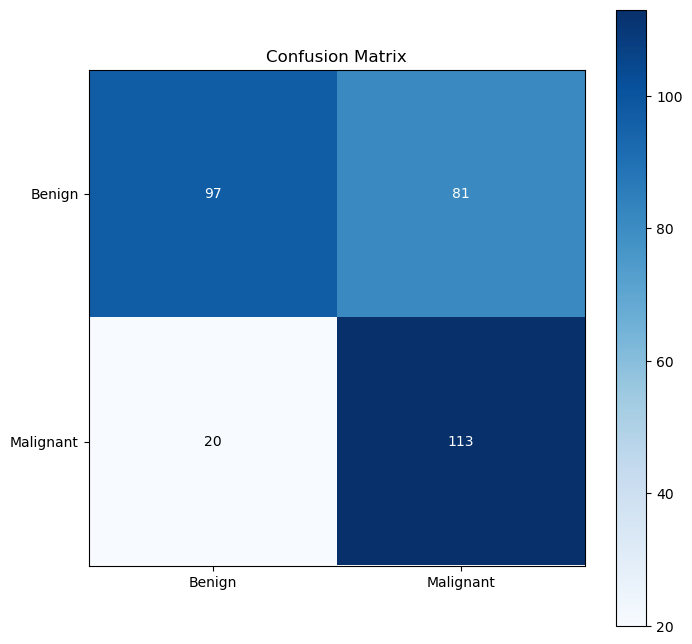

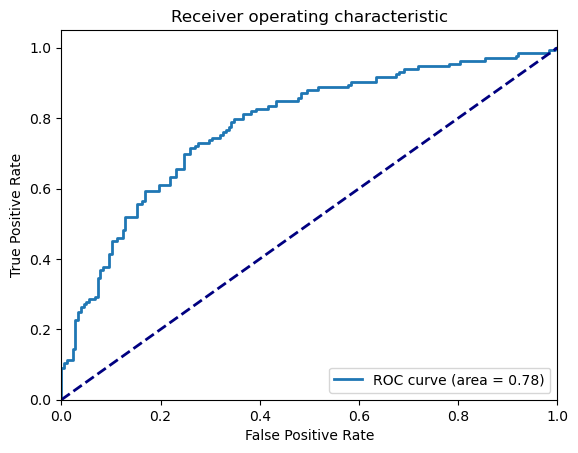

In [22]:
model.load_weights(weights+'Fine_Tune/best_model')
model.evaluate(test)
prediction = model.predict(test)
cm = Model_Training.confusion_matrix(test,prediction)
AUC = Model_Training.AUC(test,prediction)
tf.keras.backend.clear_session()

20/20 [==============================] - 1s 48ms/step - loss: 0.6755 - categorical_accuracy: 0.6624 - precision: 0.5761 - recall: 0.7970 - auc: 0.7098

# EfficientNet

In [23]:
weights = '/home/jj/FYP/Checkpoint/EffcientNetB3_CBIS_DDSM_3/'
train_log = '/home/jj/FYP/log/EffcientNetB3_CBIS_DDSM_3/'

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 efficientnetb3 (Functional)  (None, 10, 10, 1536)     10783535  
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              1573888   
                                                                 
 dense_1 (Dense)             (None, 8)                 8200      
                                                             

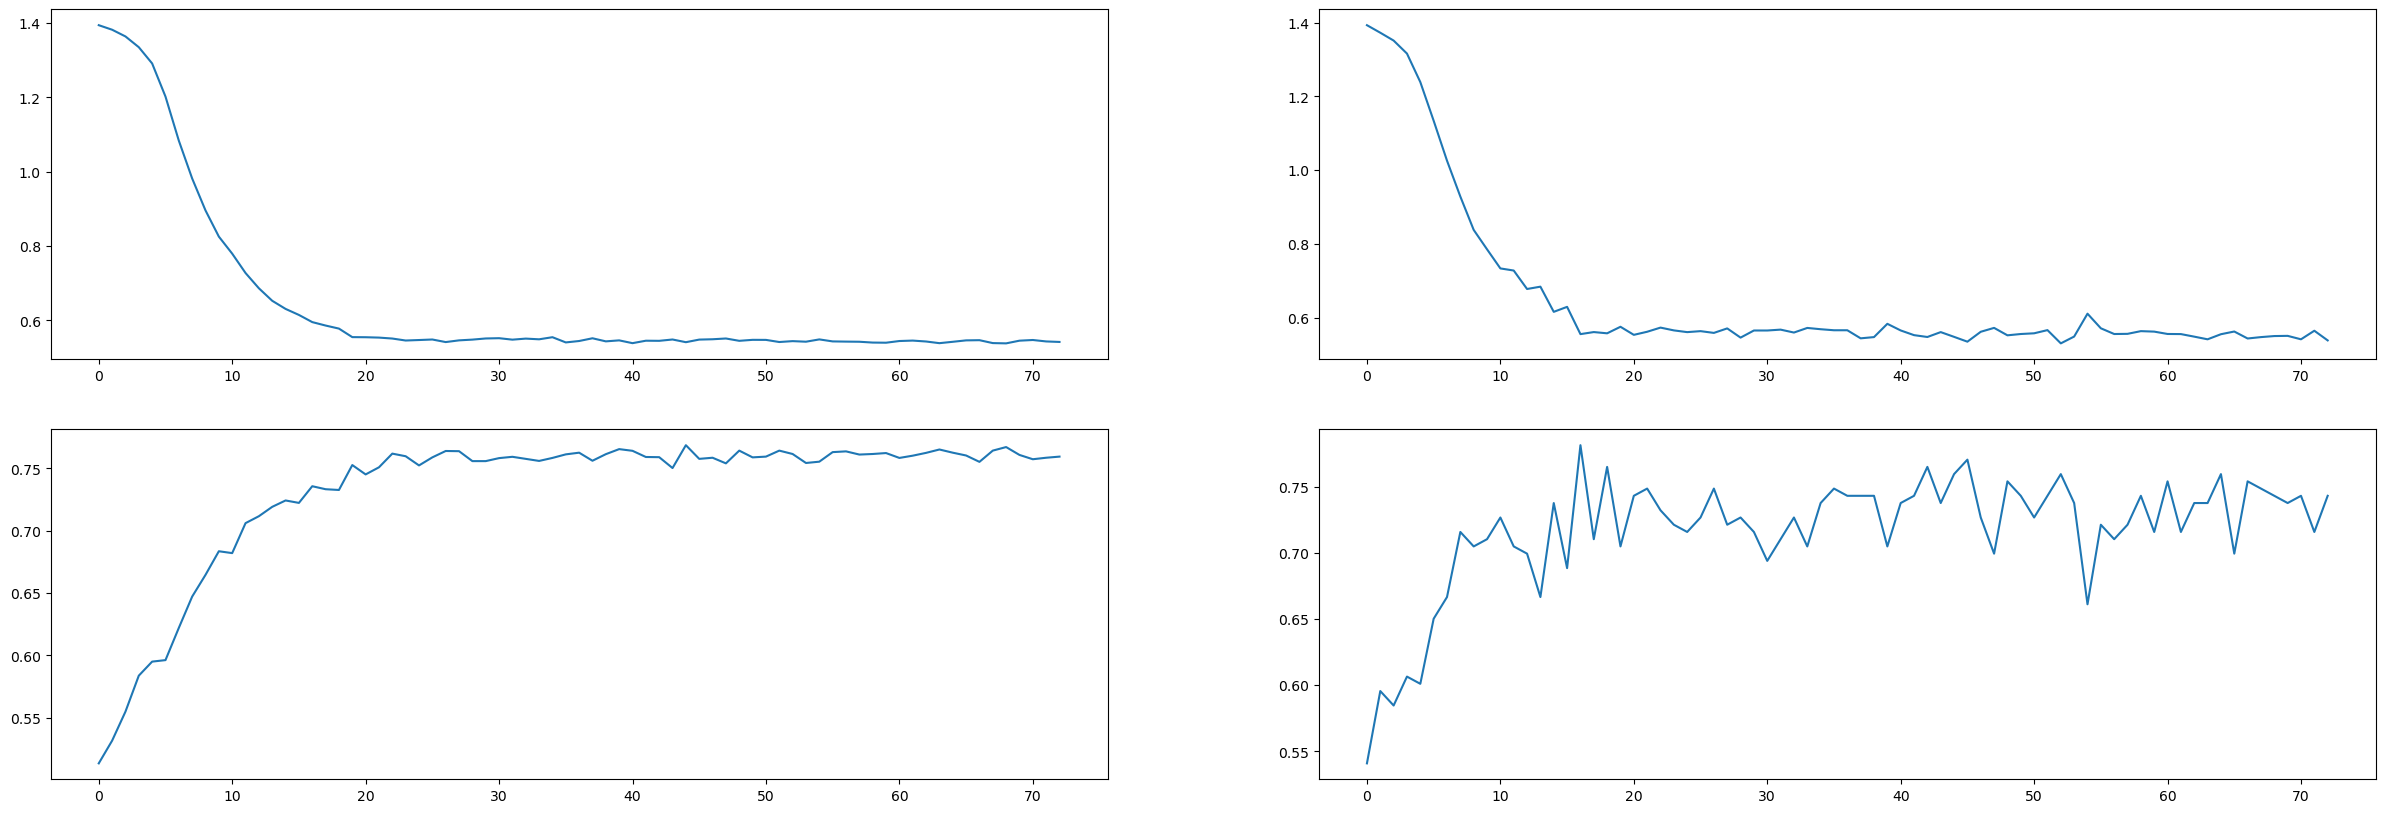

In [24]:
tf.keras.backend.clear_session()
weights = '/home/jj/FYP/Checkpoint/EffcientNetB3_CBIS_DDSM_3/'
train_log = '/home/jj/FYP/log/EffcientNetB3_CBIS_DDSM_3/'
model, effnet_dense_history = Model_Training.main(    
    'efficientnetb3',
    train,
    val,
    epochs=100,
    patience=2,
    Earlystop=20,
    augmentation = True,
    trainable_layers = False,
    regulariser=tf.keras.regularizers.l2(l2=0.1),
    train_log= train_log+'dense.csv',
    load_weights = False,
    save_weights = weights+'Dense/best_model',
    learning_rate=1e-4,init_lr=1e-6,
    optimiser=tf.keras.optimizers.Adam(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Recall(class_id=0),tf.keras.metrics.Recall(class_id=1)],
    callbacks = [PrintLR()],
    img_height=img_height,img_width=img_width)
tf.keras.backend.clear_session()

## Fine Tune

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 efficientnetb3 (Functional)  (None, 10, 10, 1536)     10783535  
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              1573888   
                                                                 
 dense_1 (Dense)             (None, 8)                 8200      
                                                             

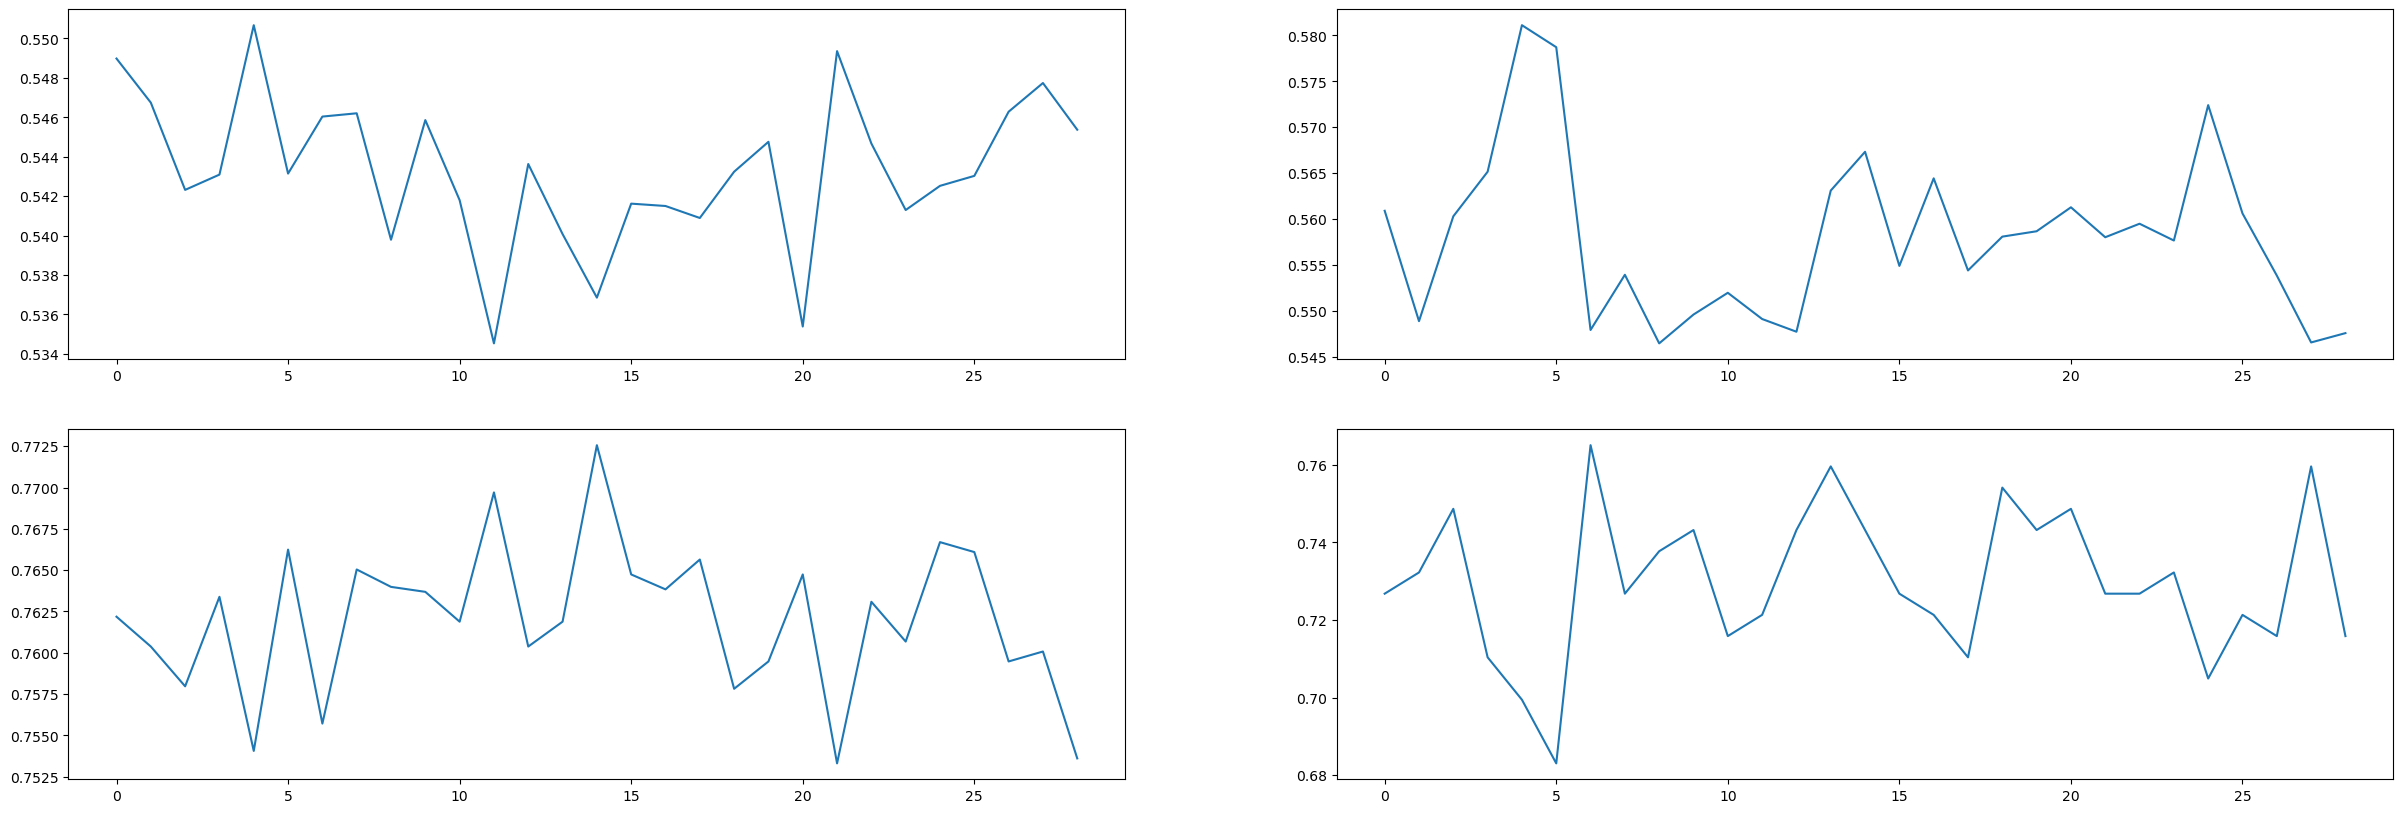

In [25]:
tf.keras.backend.clear_session()
model, effnet_fine_tune_history = Model_Training.main(    
    'efficientnetb3',
    train,
    val,
    epochs=100,
    patience=2,
    Earlystop=20,
    augmentation = True,
    trainable_layers = 75,
    regulariser=tf.keras.regularizers.l2(l2=0.1),
    train_log= train_log+'Fine_Tune.csv',
    load_weights = weights+'Dense/best_model',
    save_weights = weights+'Fine_Tune/best_model',
    learning_rate=1e-5,init_lr=1e-7,
    optimiser=tf.keras.optimizers.legacy.SGD(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Recall(class_id=0),tf.keras.metrics.Recall(class_id=1)],
    callbacks = [PrintLR()],
    img_height=img_height,img_width=img_width)

## Test

In [26]:
tf.keras.backend.clear_session()
metric = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=1),tf.keras.metrics.Recall(class_id=1),
          tf.keras.metrics.AUC()]
model = Model_Training.build_model('efficientnetb3',augmentation=False,Flatten='global_average_pooling',load_weights=weights+'Fine_Tune/best_model',metrics=metric)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 efficientnetb3 (Functional)  (None, 10, 10, 1536)     10783535  
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              1573888   
                                                                 
 dense_1 (Dense)             (None, 8)                 8200      
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                             

In [27]:
store_misclassified = misclassified_store+'efficientnetb3/'
model.evaluate(test)
misclassified_inceptionv3_test = Model_Training.store_misclassified(model,test,store_misclassified+'test/')
misclassified_inceptionv3_train = Model_Training.store_misclassified(model,train_test,store_misclassified+'train/')
misclassified_inceptionv3_val = Model_Training.store_misclassified(model,val_test,store_misclassified+'val/')

12/12 [==============================] - 1s 85ms/step


20/20 [==============================] - 1s 56ms/step


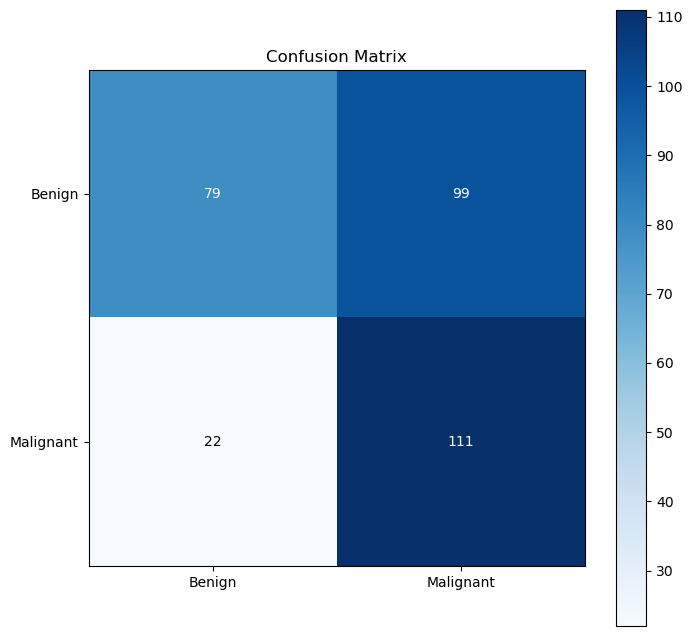

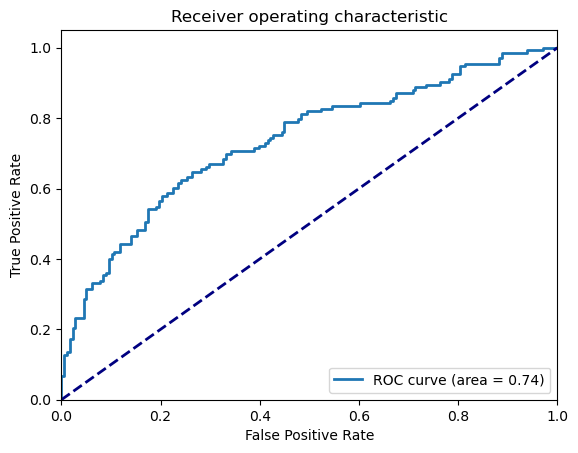

In [28]:
model.load_weights(weights+'Fine_Tune/best_model')
model.evaluate(test)
prediction = model.predict(test)
cm = Model_Training.confusion_matrix(test,prediction)
AUC = Model_Training.AUC(test,prediction)
tf.keras.backend.clear_session()

20/20 [==============================] - 2s 68ms/step - loss: 0.6316 - categorical_accuracy: 0.6495 - precision: 0.5674 - recall: 0.7594 - auc: 0.7006

# ConvNext

In [29]:
weights = '/home/jj/FYP/Checkpoint/Convnext_CBIS_DDSM_3/'
train_log = '/home/jj/FYP/log/Convnext_CBIS_DDSM_3/'

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 convnext_base (Functional)  (None, 9, 9, 1024)        87566464  
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              1049600   
                                                                 
 dense_1 (Dense)             (None, 8)                 8200      
                                                             

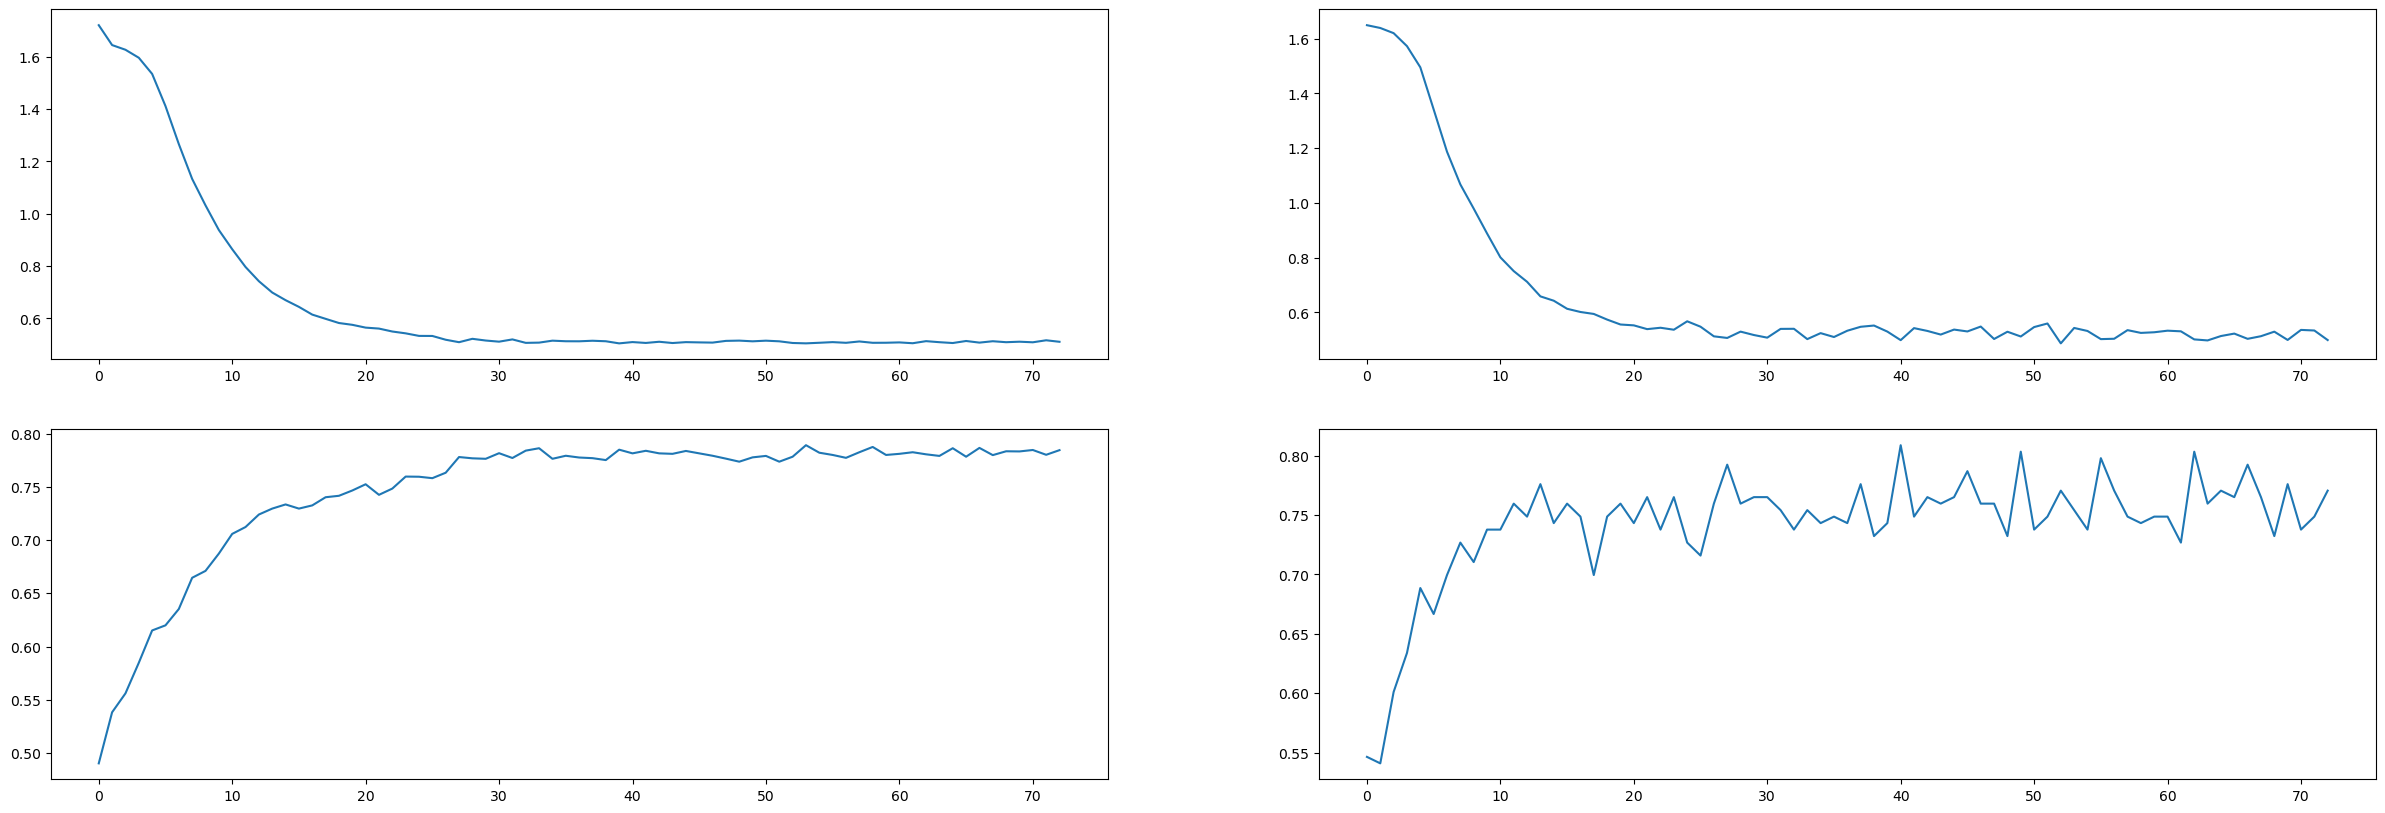

In [30]:
tf.keras.backend.clear_session()
model, convnext_dense_history = Model_Training.main(    
    'convnext',
    train,
    val,
    epochs=100,
    patience=2,
    Earlystop=20,
    augmentation = True,
    trainable_layers = False,
    regulariser=tf.keras.regularizers.l2(l2=0.1),
    train_log= train_log+'dense.csv',
    load_weights = False,
    save_weights = weights+'Dense/best_model',
    learning_rate=1e-4,init_lr=1e-6,
    optimiser=tf.keras.optimizers.Adam(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()],
    img_height=img_height,img_width=img_width)

## Fine Tune

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 convnext_base (Functional)  (None, 9, 9, 1024)        87566464  
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              1049600   
                                                                 
 dense_1 (Dense)             (None, 8)                 8200      
                                                             

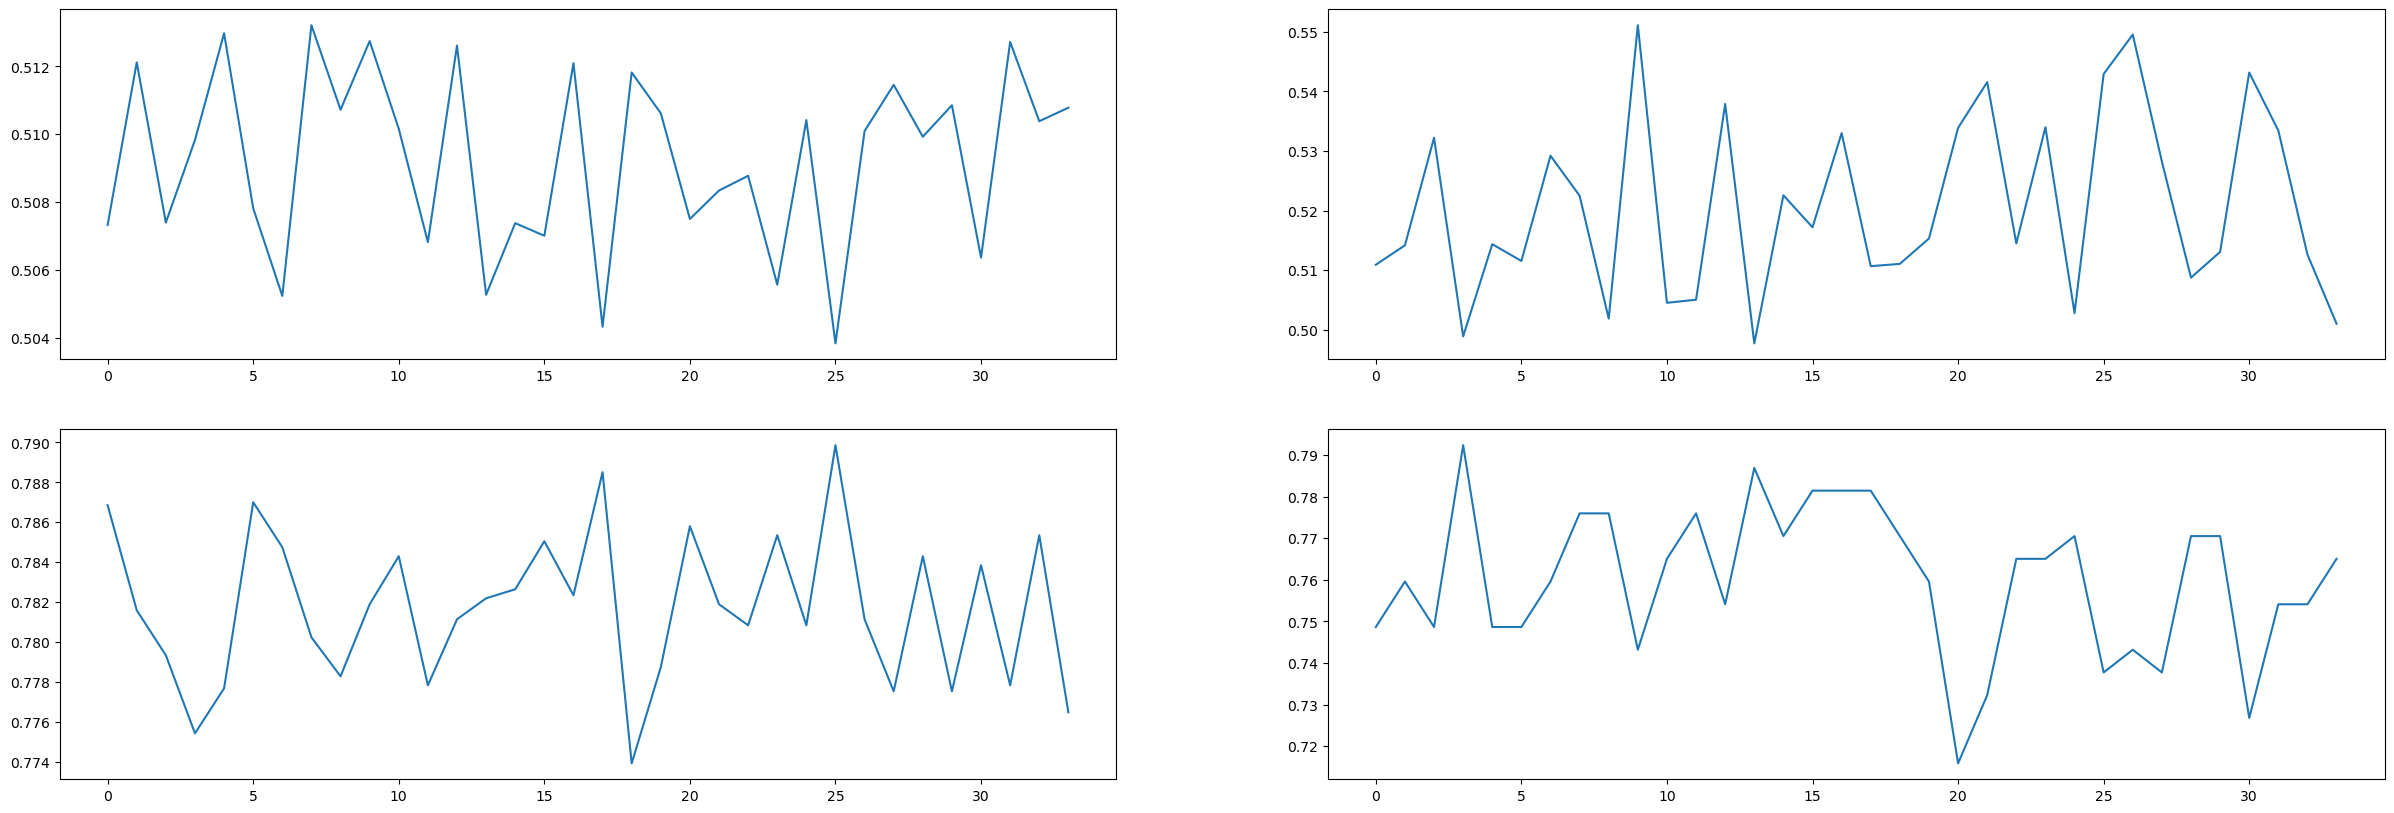

In [31]:
tf.keras.backend.clear_session()
weights = '/home/jj/FYP/Checkpoint/Convnext_CBIS_DDSM_3/'
train_log = '/home/jj/FYP/log/Convnext_CBIS_DDSM_3/'
model, convnext_fine_tune_history = Model_Training.main(    
    'convnext',
    train,
    val,
    epochs=100,
    patience=2,
    Earlystop=20,
    augmentation = True,
    # Top 25 layers are the stage 3 blocks
    trainable_layers = 25,
    regulariser=tf.keras.regularizers.l2(l2=0.1),
    train_log= train_log+'Fine_Tune.csv',
    load_weights = weights+'Dense/best_model',
    save_weights = weights+'Fine_Tune/best_model',
    learning_rate=1e-4,init_lr=1e-6,
    optimiser=tf.keras.optimizers.legacy.SGD(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()],
    img_height=img_height,img_width=img_width)

## Test

In [32]:
tf.keras.backend.clear_session()
metric = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=1),tf.keras.metrics.Recall(class_id=1),
          tf.keras.metrics.AUC()]
model = Model_Training.build_model('convnext',augmentation=False,Flatten='global_average_pooling',load_weights=weights+'Fine_Tune/best_model',metrics=metric)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 convnext_base (Functional)  (None, 9, 9, 1024)        87566464  
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              1049600   
                                                                 
 dense_1 (Dense)             (None, 8)                 8200      
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                             

In [33]:
store_misclassified = misclassified_store+'convnext/'
model.evaluate(test)
misclassified_inceptionv3_test = Model_Training.store_misclassified(model,test,store_misclassified+'test/')
misclassified_inceptionv3_train = Model_Training.store_misclassified(model,train_test,store_misclassified+'train/')
misclassified_inceptionv3_val = Model_Training.store_misclassified(model,val_test,store_misclassified+'val/')

12/12 [==============================] - 3s 210ms/step


20/20 [==============================] - 4s 212ms/step


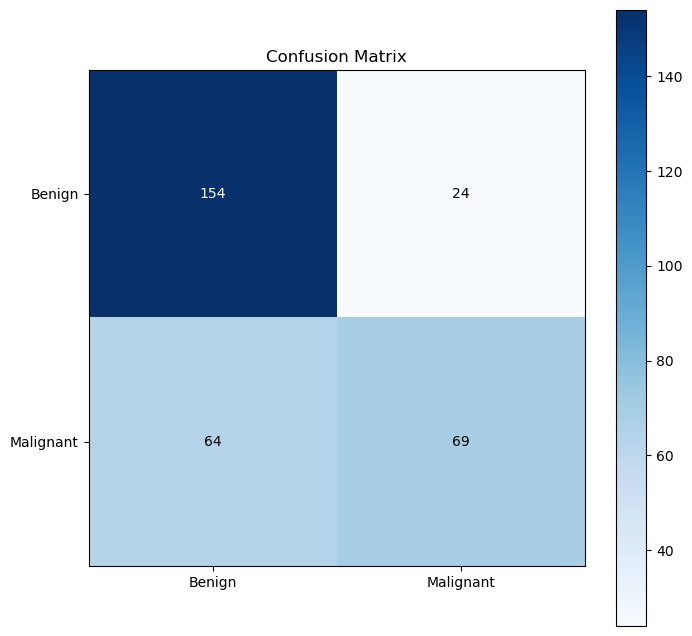

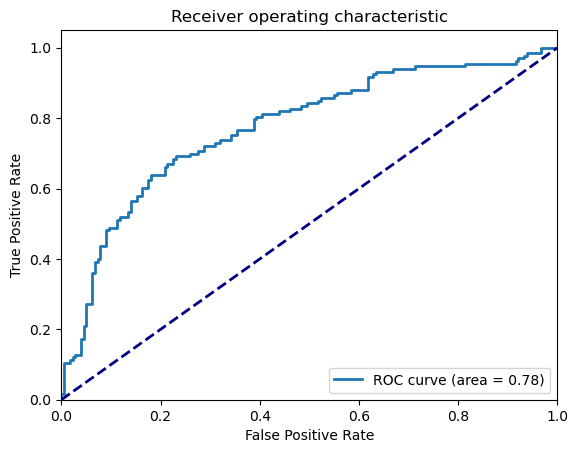

In [34]:
model.load_weights(weights+'Fine_Tune/best_model')
model.evaluate(test)
prediction = model.predict(test)
cm = Model_Training.confusion_matrix(test,prediction)
AUC = Model_Training.AUC(test,prediction)
tf.keras.backend.clear_session()

# EfficientNet V2M

## Initialising

In [6]:
weights = '/home/jj/FYP/Checkpoint/Efficientnetv2m_CBIS_DDSM_3/'
train_log = '/home/jj/FYP/log/Efficientnetv2m_CBIS_DDSM_3/'

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 efficientnetv2-m (Functiona  (None, 10, 10, 1280)     53150388  
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dense_1 (Dense)             (None, 8)                 8200  

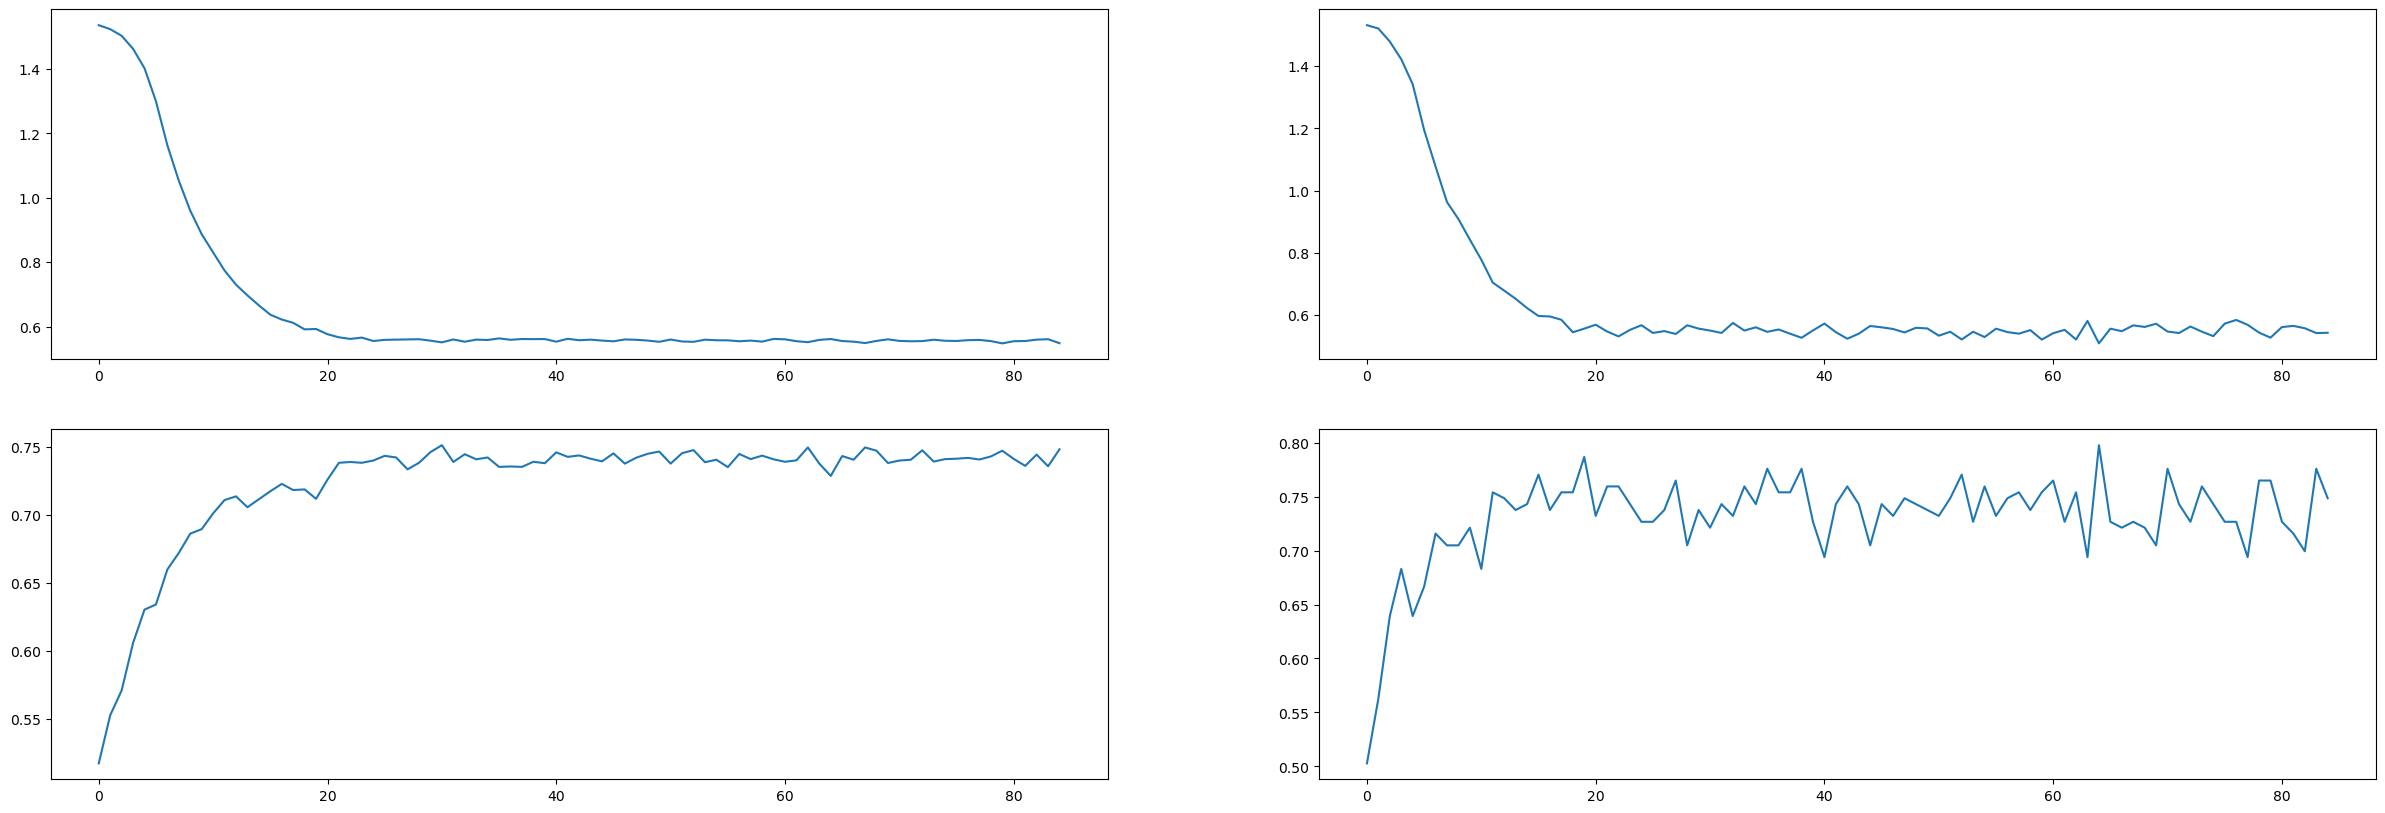

In [35]:
tf.keras.backend.clear_session()


model, effnetv2m_dense_history = Model_Training.main(    
    'efficientnetv2m',
    train,
    val,
    epochs=100,
    patience=2,
    Earlystop=20,
    augmentation = True,
    trainable_layers = False,
    regulariser=tf.keras.regularizers.l2(l2=0.1),
    train_log= train_log+'dense.csv',
    load_weights = False,
    save_weights = weights+'Dense/best_model',
    learning_rate=1e-4,init_lr=1e-6,
    optimiser=tf.keras.optimizers.Adam(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()],
    img_height=img_height,img_width=img_width)

## Fine Tuning

In [36]:
tf.keras.backend.clear_session()
model, effnetv2m_fine_tune_history = Model_Training.main(    
    'efficientnetv2m',
    train,
    val,
    epochs=100,
    patience=2,
    Earlystop=20,
    augmentation = True,
    trainable_layers = 75,
    regulariser=tf.keras.regularizers.l2(l2=0.1),
    train_log= train_log+'Fine_Tune.csv',
    load_weights = weights+'Dense/best_model',
    save_weights = weights+'Fine_Tune/best_model',
    learning_rate=1e-4,init_lr=1e-6,
    optimiser=tf.keras.optimizers.legacy.SGD(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()],
    img_height=img_height,img_width=img_width)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 efficientnetv2-m (Functiona  (None, 10, 10, 1280)     53150388  
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dense_1 (Dense)             (None, 8)                 8200  

: 

: 

## Test

In [7]:
tf.keras.backend.clear_session()
metric = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=1),tf.keras.metrics.Recall(class_id=1),
          tf.keras.metrics.AUC()]
model = Model_Training.build_model('efficientnetv2m',augmentation=False,Flatten='global_average_pooling',load_weights=weights+'Fine_Tune/best_model',metrics=metric)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 efficientnetv2-m (Functiona  (None, 10, 10, 1280)     53150388  
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dense_1 (Dense)             (None, 8)                 8200      
                                                                 
 dropout (Dropout)           (None, 8)                 0     

2023-03-10 21:13:49.507137: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-03-10 21:13:52.173353: W tensorflow/tsl/framework/bfc_allocator.cc:360] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


 2/20 [==>...........................] - ETA: 2s - loss: 0.7963 - categorical_accuracy: 0.5625 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5137  

2023-03-10 21:13:52.465388: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


20/20 [==============================] - 4s 117ms/step


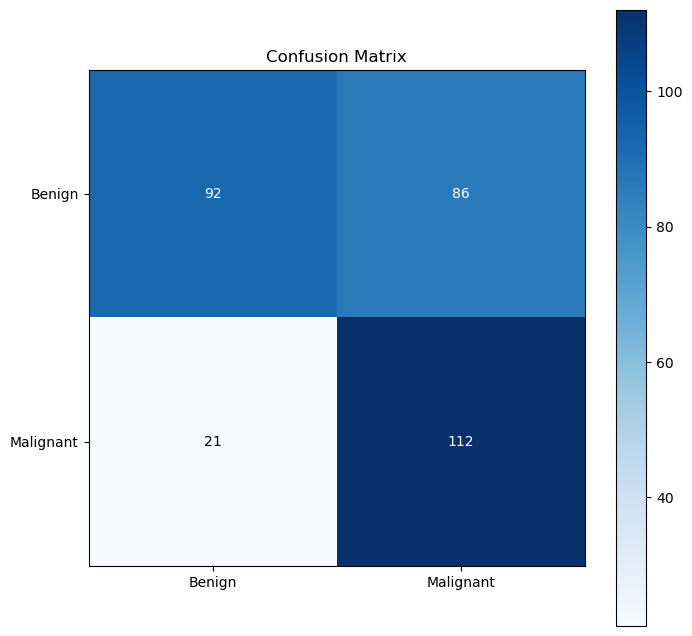

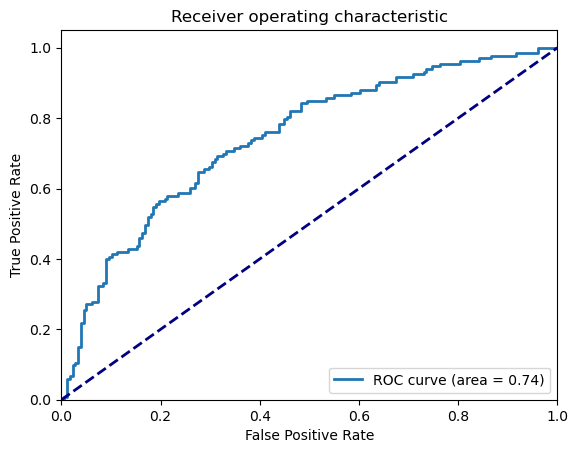

: 

In [8]:
model.load_weights(weights+'Fine_Tune/best_model')
model.evaluate(test)
prediction = model.predict(test)
cm = Model_Training.confusion_matrix(test,prediction)
AUC = Model_Training.AUC(test,prediction)
tf.keras.backend.clear_session()